In [130]:

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import random
from scipy.stats import zscore
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, Bidirectional, LayerNormalization, GlobalAveragePooling1D
from sklearn.model_selection import TimeSeriesSplit
from scipy import stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import plotly.express as px
import plotly.graph_objects as go
from scipy.signal import savgol_filter
import itertools
from scipy.stats import boxcox


In [131]:
df =pd.read_excel('E-Commerce Transactions Volume.xlsx')

# DATA PREPROCESSING 

In [132]:
df.head()

Date  E-Commerce Transactions: Volume
0 2018-12-30                              456
1 2018-12-31                              559
2 2019-01-01                              471
3 2019-01-02                              736
4 2019-01-03                              682

In [133]:
df.shape


(2365, 2)

In [134]:
# missing data
df.isna().sum().sum()


0

In [135]:
df.columns

Index(['Date', 'E-Commerce Transactions: Volume'], dtype='object')

In [136]:
df['Date'] = pd.to_datetime(df['Date'])  # ensure it's datetime
df.set_index('Date', inplace=True)

#sort by date just in case
df.sort_index(inplace=True)

# Quick check
df.head()

E-Commerce Transactions: Volume
Date                                       
2018-12-30                              456
2018-12-31                              559
2019-01-01                              471
2019-01-02                              736
2019-01-03                              682

In [137]:
df.rename(columns={'E-Commerce Transactions: Volume': 'Volume'}, inplace=True)

# Verify
df.head()

Volume
Date              
2018-12-30     456
2018-12-31     559
2019-01-01     471
2019-01-02     736
2019-01-03     682

In [138]:
df.describe()


Volume
count   2365.000000
mean    1405.074841
std      820.198225
min        9.000000
25%      903.000000
50%     1247.000000
75%     1700.000000
max    14263.000000

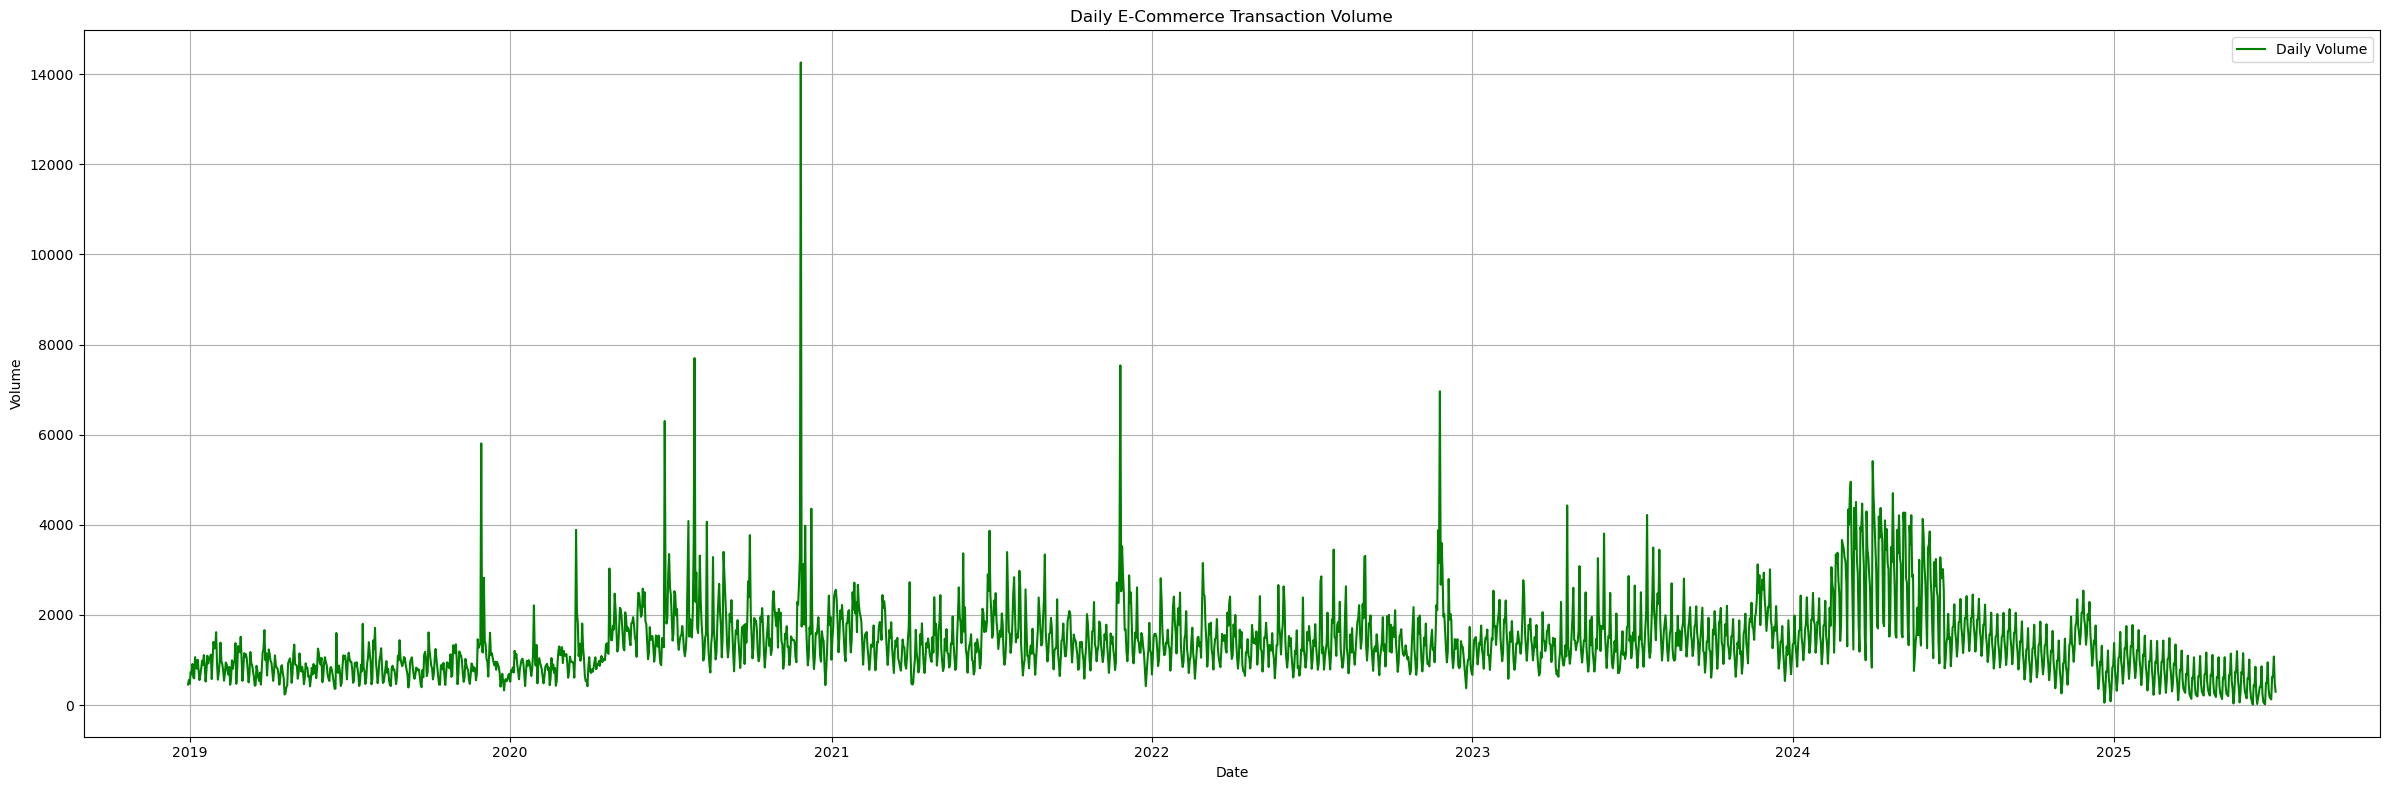

In [139]:
# Plot side by side
plt.figure(figsize=(24,8))

# Daily plot
plt.plot(df['Volume'], label='Daily Volume', color='green')
plt.title('Daily E-Commerce Transaction Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [140]:
result = adfuller(df['Volume'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

if result[1] <= 0.05:
    print("The time series is stationary")
else:
    print("The time series is non-stationary")


ADF Statistic: -3.197657467532881
p-value: 0.020120675239250693
Critical Values:
   1%: -3.4331512397333626
   5%: -2.8627775348975866
   10%: -2.567428794167024
The time series is stationary


Text(0, 0.5, 'Frequency')

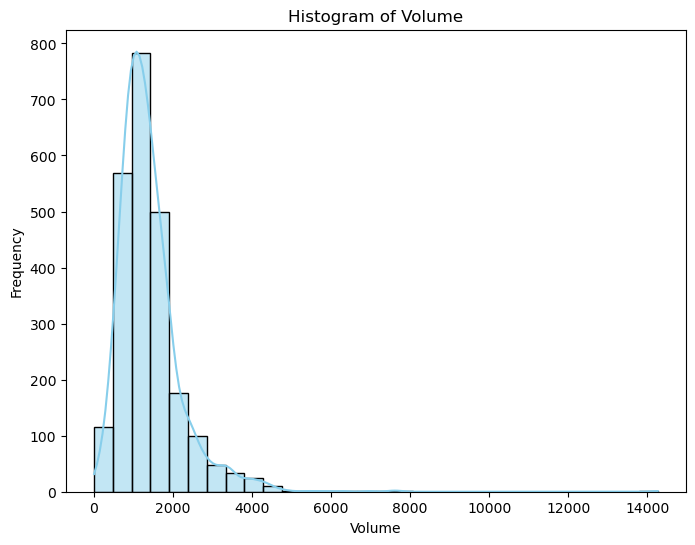

In [141]:
# Plotting the distribution
# Histogram
plt.figure(figsize=(8,6))
sns.histplot(df['Volume'], bins=30, kde=True, color='skyblue')
plt.title('Histogram of Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')


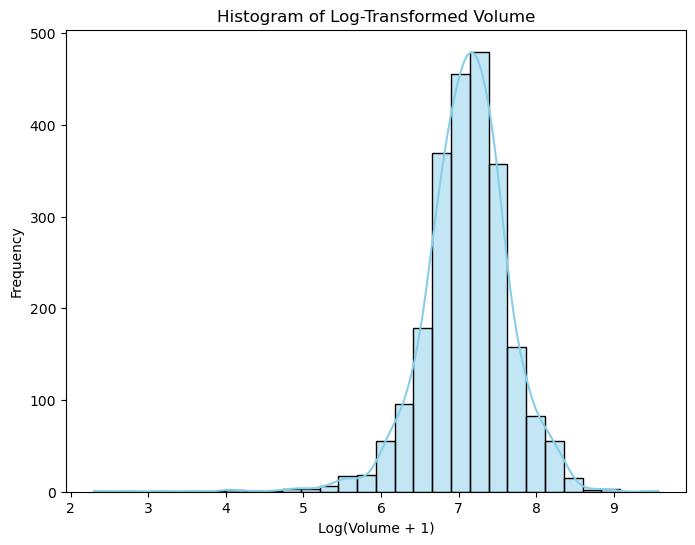

In [142]:

# Apply log transformation
df['Volume_log'] = np.log1p(df['Volume'])  # log(1 + x) to handle zeros

# Plot histogram
plt.figure(figsize=(8,6))
sns.histplot(df['Volume_log'], bins=30, kde=True, color='skyblue')
plt.title('Histogram of Log-Transformed Volume')
plt.xlabel('Log(Volume + 1)')
plt.ylabel('Frequency')
plt.show()

In [143]:
def skewness(data):
    mean_value = np.mean(data)
    std_dev = np.std(data)
    n = len(data)
    skew = (sum((x - mean_value) ** 3 for x in data) * n) / ((n - 1) * (n - 2) * std_dev ** 3)
    return skew


# Calculate skewness
result = skewness(df['Volume_log'])
print("Skewness:", result)

Skewness: -1.1169356053007267


In [144]:
# Calculate skewness
result = skewness(df['Volume'])
print("Skewness:", result)

Skewness: 3.3104423952382893


Optimal lambda for Box-Cox: 0.2678114568138054
Skewness after Box-Cox: 0.12043707903504941


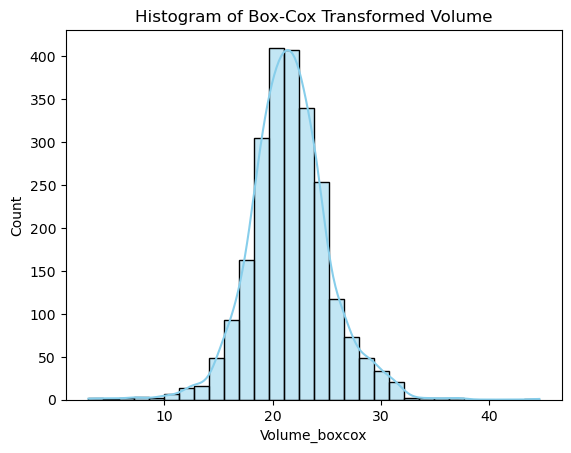

In [145]:

# Apply Box-Cox
df['Volume_boxcox'], lam = boxcox(df['Volume'])  # add 1 to avoid zero
print("Optimal lambda for Box-Cox:", lam)

# Check skewness
print("Skewness after Box-Cox:", df['Volume_boxcox'].skew())

# Plot histogram
sns.histplot(df['Volume_boxcox'], bins=30, kde=True, color='skyblue')
plt.title('Histogram of Box-Cox Transformed Volume')
plt.show()

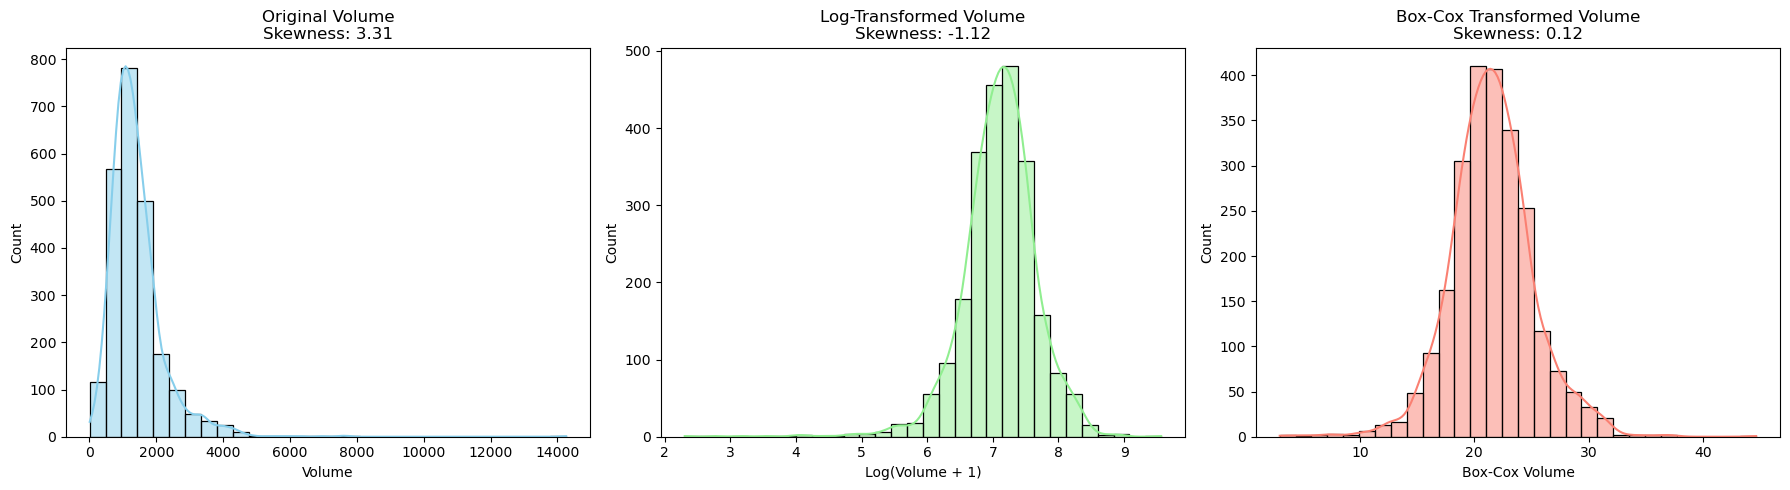

In [146]:

# Plotting side by side
plt.figure(figsize=(18,5))

# Original
plt.subplot(1,3,1)
sns.histplot(df['Volume'], bins=30, kde=True, color='skyblue')
plt.title(f'Original Volume\nSkewness: {df["Volume"].skew():.2f}')
plt.xlabel('Volume')

# Log-transformed
plt.subplot(1,3,2)
sns.histplot(df['Volume_log'], bins=30, kde=True, color='lightgreen')
plt.title(f'Log-Transformed Volume\nSkewness: {df["Volume_log"].skew():.2f}')
plt.xlabel('Log(Volume + 1)')

# Box-Cox transformed
plt.subplot(1,3,3)
sns.histplot(df['Volume_boxcox'], bins=30, kde=True, color='salmon')
plt.title(f'Box-Cox Transformed Volume\nSkewness: {df["Volume_boxcox"].skew():.2f}')
plt.xlabel('Box-Cox Volume')

plt.tight_layout()
plt.show()

Total rolling Z-score outliers (Box-Cox): 14


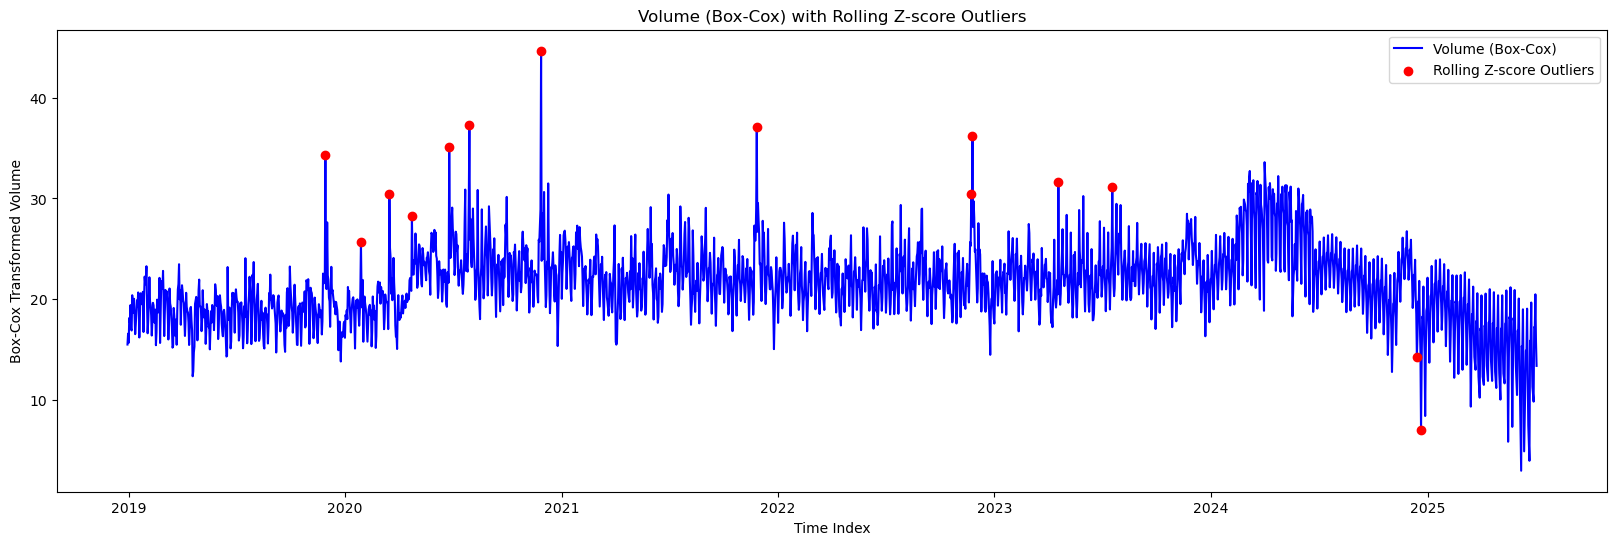

In [147]:

# Parameters
window = 30  
z_threshold = 3  # Z-score threshold

# Compute rolling mean and std on Box-Cox transformed data
rolling_mean = df['Volume_boxcox'].rolling(window=window, min_periods=1).mean()
rolling_std = df['Volume_boxcox'].rolling(window=window, min_periods=1).std()

# Compute rolling Z-score
df['rolling_zscore_boxcox'] = (df['Volume_boxcox'] - rolling_mean) / rolling_std

# Detect outliers
outliers_rolling_z_boxcox = df[(df['rolling_zscore_boxcox'] > z_threshold) | 
                               (df['rolling_zscore_boxcox'] < -z_threshold)]

print(f"Total rolling Z-score outliers (Box-Cox): {len(outliers_rolling_z_boxcox)}")

# Visualization
plt.figure(figsize=(20,6))
plt.plot(df['Volume_boxcox'], label='Volume (Box-Cox)', color='blue')
plt.scatter(outliers_rolling_z_boxcox.index, 
            outliers_rolling_z_boxcox['Volume_boxcox'], 
            color='red', label='Rolling Z-score Outliers', zorder=5)
plt.title("Volume (Box-Cox) with Rolling Z-score Outliers")
plt.xlabel("Time Index")
plt.ylabel("Box-Cox Transformed Volume")
plt.legend()
plt.show()

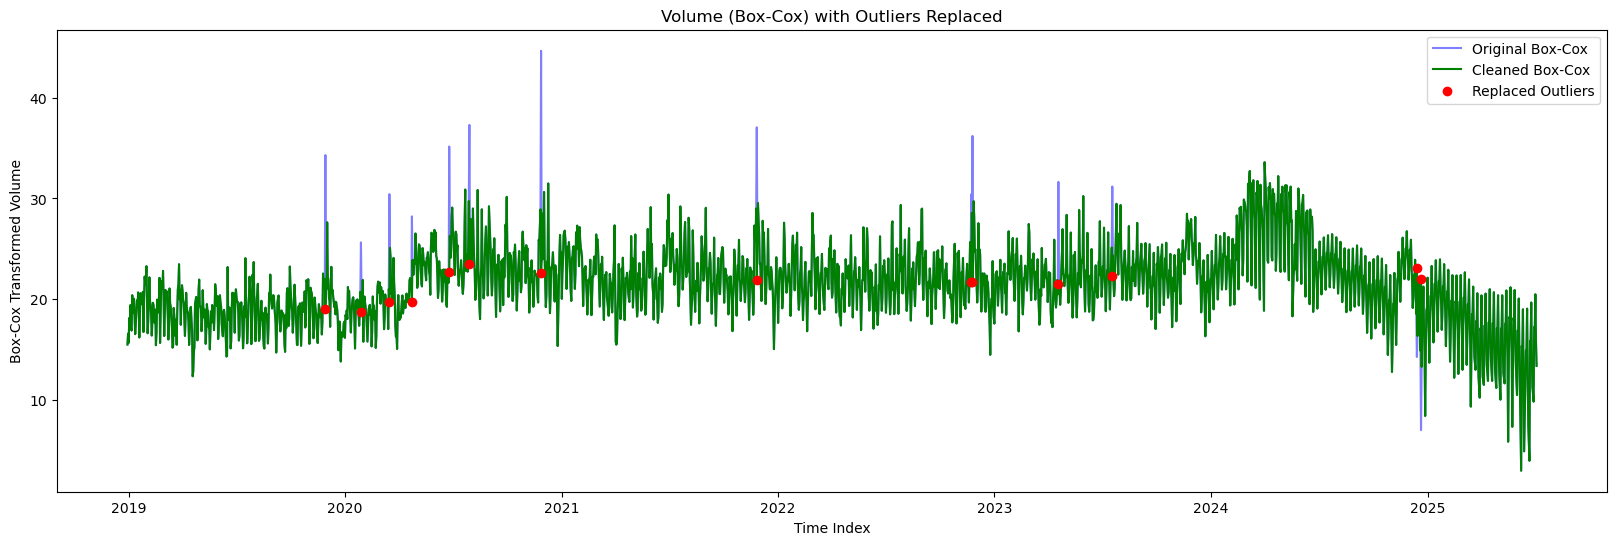

In [148]:
# Copy the data to a new column
df['Volume_boxcox_clean'] = df['Volume_boxcox'].copy()

# Replace outliers with rolling median
window = 30  
rolling_median = df['Volume_boxcox'].rolling(window=window, min_periods=1).median()

# Identify outliers
outliers_mask = (df['rolling_zscore_boxcox'] > z_threshold) | (df['rolling_zscore_boxcox'] < -z_threshold)

# Replace outliers
df.loc[outliers_mask, 'Volume_boxcox_clean'] = rolling_median[outliers_mask]

# Visualization
plt.figure(figsize=(20,6))
plt.plot(df['Volume_boxcox'], label='Original Box-Cox', color='blue', alpha=0.5)
plt.plot(df['Volume_boxcox_clean'], label='Cleaned Box-Cox', color='green')
plt.scatter(df.index[outliers_mask], 
            df['Volume_boxcox_clean'][outliers_mask], 
            color='red', label='Replaced Outliers', zorder=5)
plt.title("Volume (Box-Cox) with Outliers Replaced")
plt.xlabel("Time Index")
plt.ylabel("Box-Cox Transformed Volume")
plt.legend()
plt.show()


In [149]:
df

Volume  Volume_log  Volume_boxcox  rolling_zscore_boxcox  \
Date                                                                   
2018-12-30     456    6.124683      15.509000                    NaN   
2018-12-31     559    6.327937      16.587691               0.707107   
2019-01-01     471    6.156979      15.676519              -0.427020   
2019-01-02     736    6.602588      18.141307               1.379202   
2019-01-03     682    6.526495      17.699415               0.828947   
...            ...         ...            ...                    ...   
2025-06-30     629    6.445720      17.240044               0.671754   
2025-07-01     624    6.437752      17.195262               0.672338   
2025-07-02    1077    6.982863      20.489310               1.329225   
2025-07-03     484    6.184149      15.818570               0.401083   
2025-07-04     295    5.690359      13.390513              -0.105298   

            Volume_boxcox_clean  
Date                             
2018-12-30            15.509000  
2018-12-31            16.587691  
2019-01-01            15.676519  
2019-01-02            18.141307  
2019-01-03            17.699415  
...                         ...  
2025-06-30            17.240044  
2025-07-01            17.195262  
2025-07-02            20.489310  
2025-07-03            15.818570  
2025-07-04            13.390513  

[2365 rows x 5 columns]

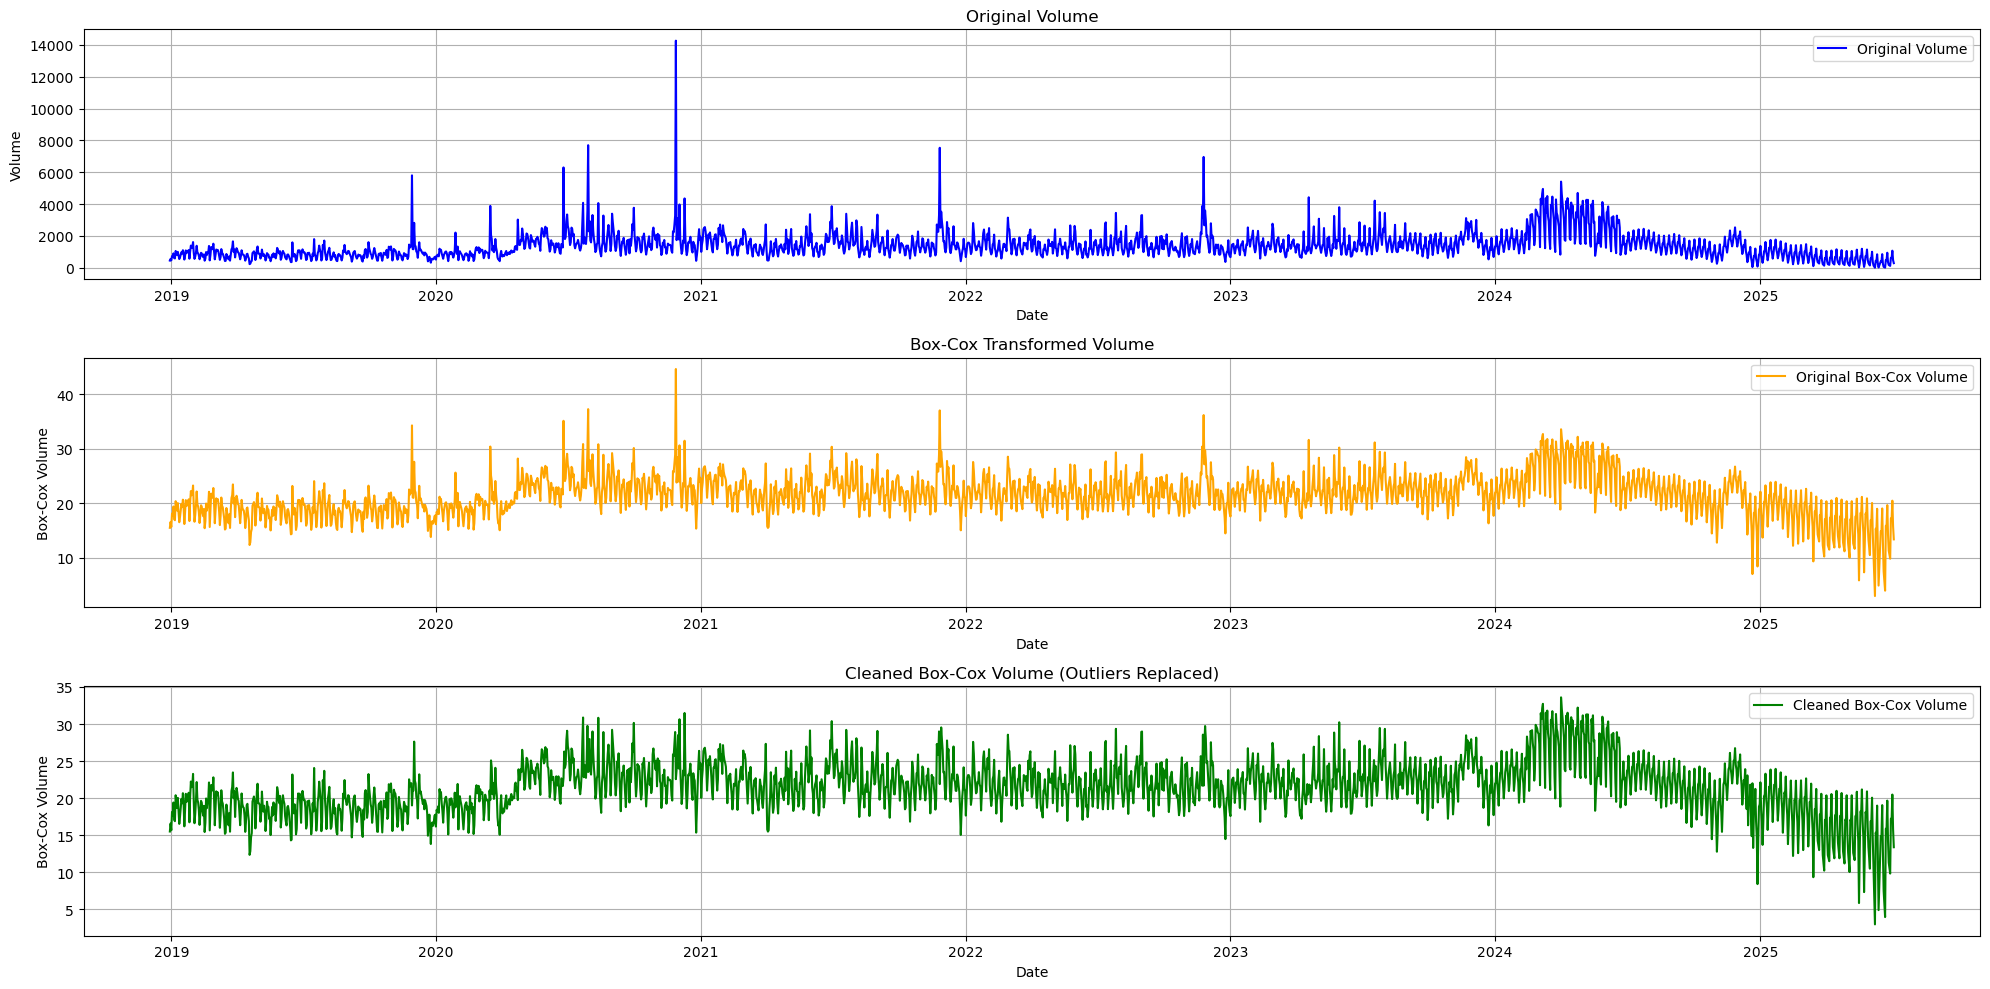

In [150]:
plt.figure(figsize=(20,10))

# Top plot: original raw Volume
plt.subplot(3, 1, 1)
plt.plot(df['Volume'], label='Original Volume', color='blue')
plt.title('Original Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)

# Middle plot: Box-Cox transformed original
plt.subplot(3, 1, 2)
plt.plot(df['Volume_boxcox'], label='Original Box-Cox Volume', color='orange')
plt.title('Box-Cox Transformed Volume')
plt.xlabel('Date')
plt.ylabel('Box-Cox Volume')
plt.legend()
plt.grid(True)

# Bottom plot: Box-Cox cleaned (outliers replaced)
plt.subplot(3, 1, 3)
plt.plot(df['Volume_boxcox_clean'], label='Cleaned Box-Cox Volume', color='green')
plt.title('Cleaned Box-Cox Volume (Outliers Replaced)')
plt.xlabel('Date')
plt.ylabel('Box-Cox Volume')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [151]:
df.columns

Index(['Volume', 'Volume_log', 'Volume_boxcox', 'rolling_zscore_boxcox',
       'Volume_boxcox_clean'],
      dtype='object')

In [152]:
df_clean = df.copy()

# Replace Volume_boxcox with the cleaned version
df_clean['Volume_boxcox'] = df_clean['Volume_boxcox_clean']

#drop the helper columns 
df_clean = df_clean.drop(columns=['Volume', 'Volume_log', 'rolling_zscore_boxcox',
       'Volume_boxcox_clean'])

# Preview
df_clean.head()

Volume_boxcox
Date                     
2018-12-30      15.509000
2018-12-31      16.587691
2019-01-01      15.676519
2019-01-02      18.141307
2019-01-03      17.699415

In [153]:
df_clean.shape

(2365, 1)

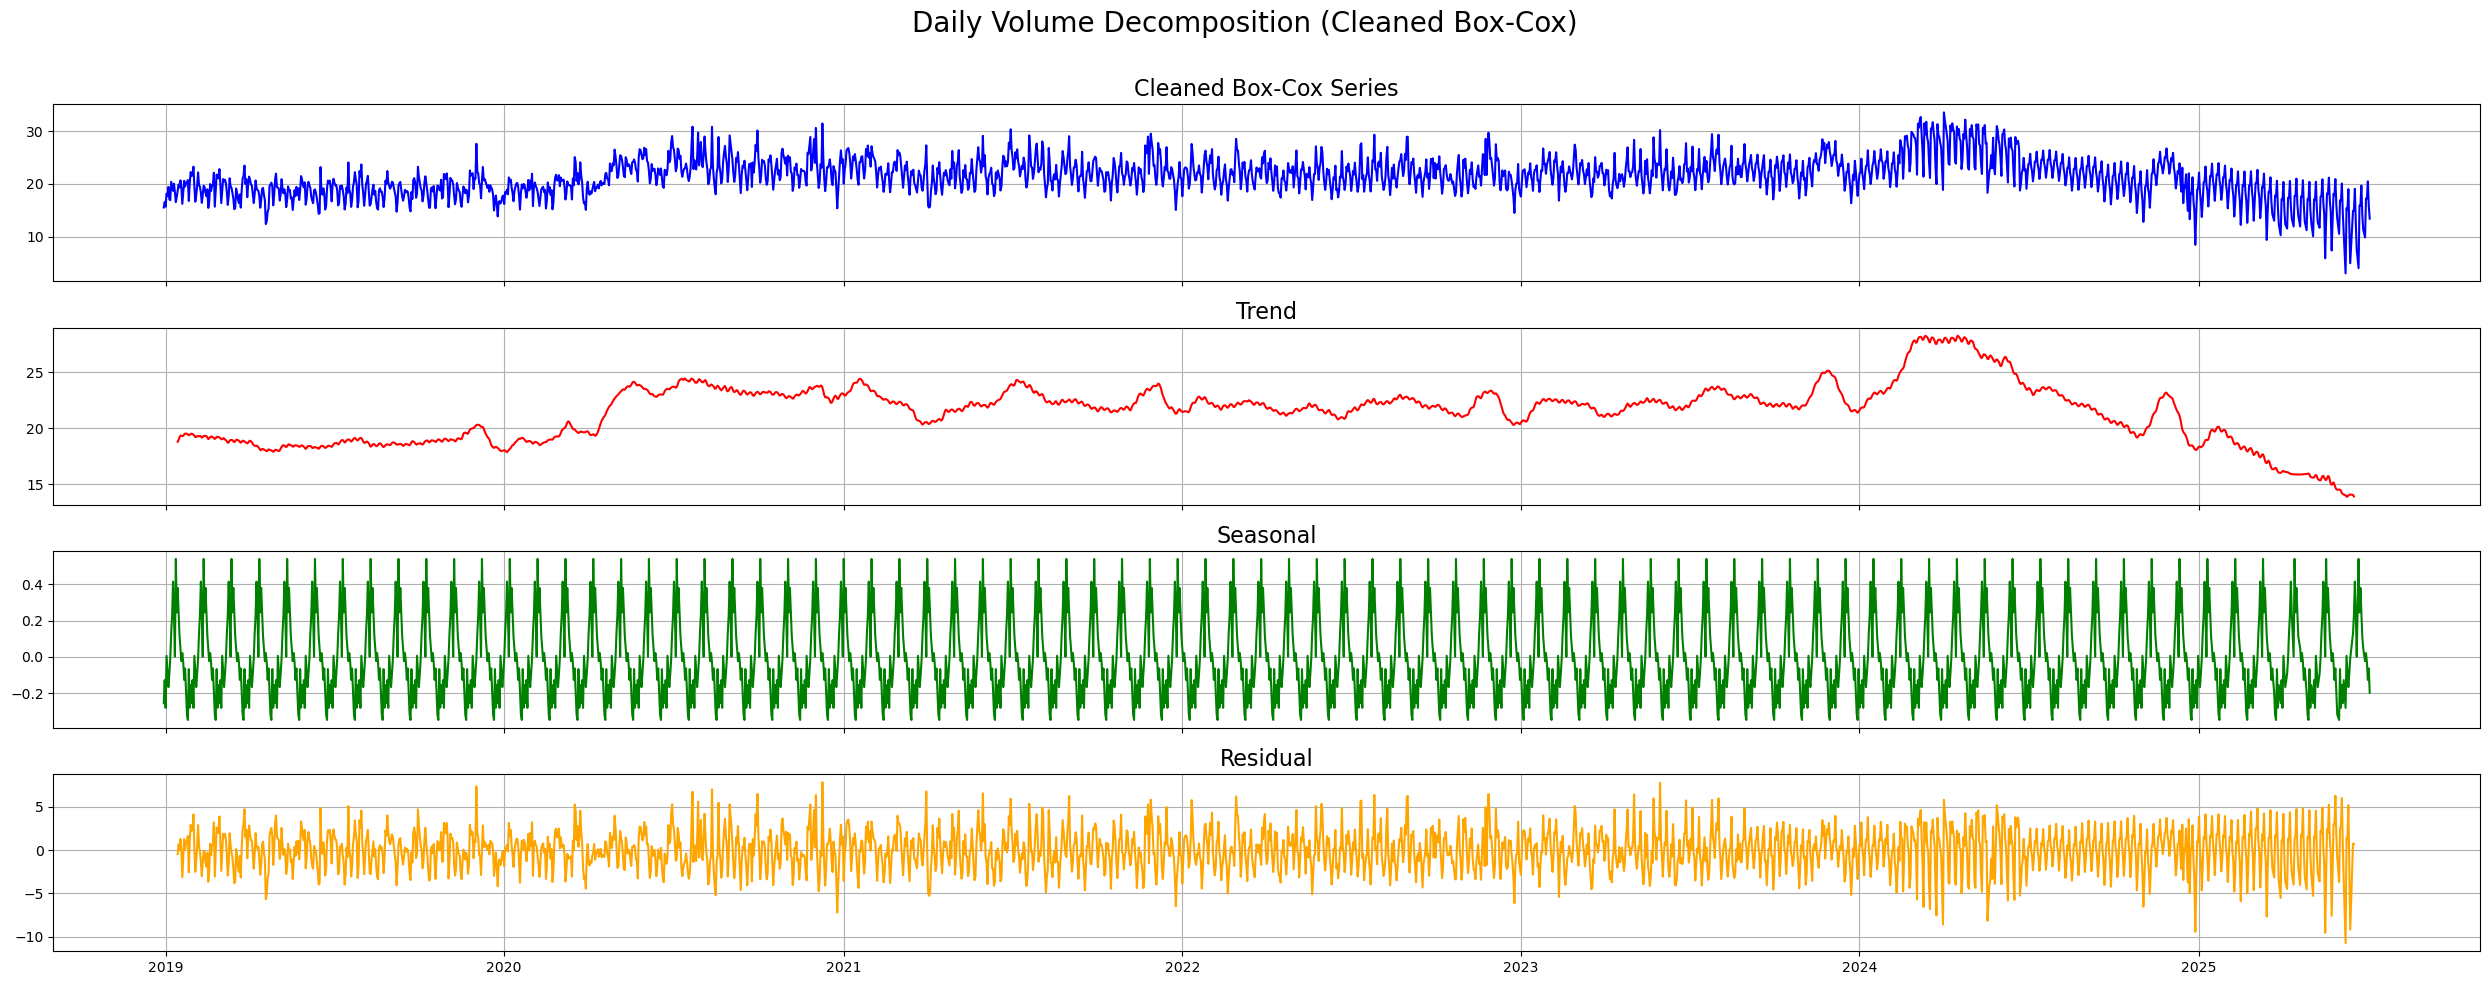

In [154]:
# Decompose daily cleaned series (Box-Cox)
decompose_daily = seasonal_decompose(df_clean['Volume_boxcox'], model='additive', period=30)

# Create a big figure manually
fig, axes = plt.subplots(4, 1, figsize=(25, 10), sharex=True)

# Original cleaned Box-Cox series
axes[0].plot(df_clean['Volume_boxcox'], color='blue')
axes[0].set_title('Cleaned Box-Cox Series', fontsize=16)
axes[0].grid(True)

# Trend
axes[1].plot(decompose_daily.trend, color='red')
axes[1].set_title('Trend', fontsize=16)
axes[1].grid(True)

# Seasonal
axes[2].plot(decompose_daily.seasonal, color='green')
axes[2].set_title('Seasonal', fontsize=16)
axes[2].grid(True)

# Residual
axes[3].plot(decompose_daily.resid, color='orange')
axes[3].set_title('Residual', fontsize=16)
axes[3].grid(True)

plt.suptitle('Daily Volume Decomposition (Cleaned Box-Cox)', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


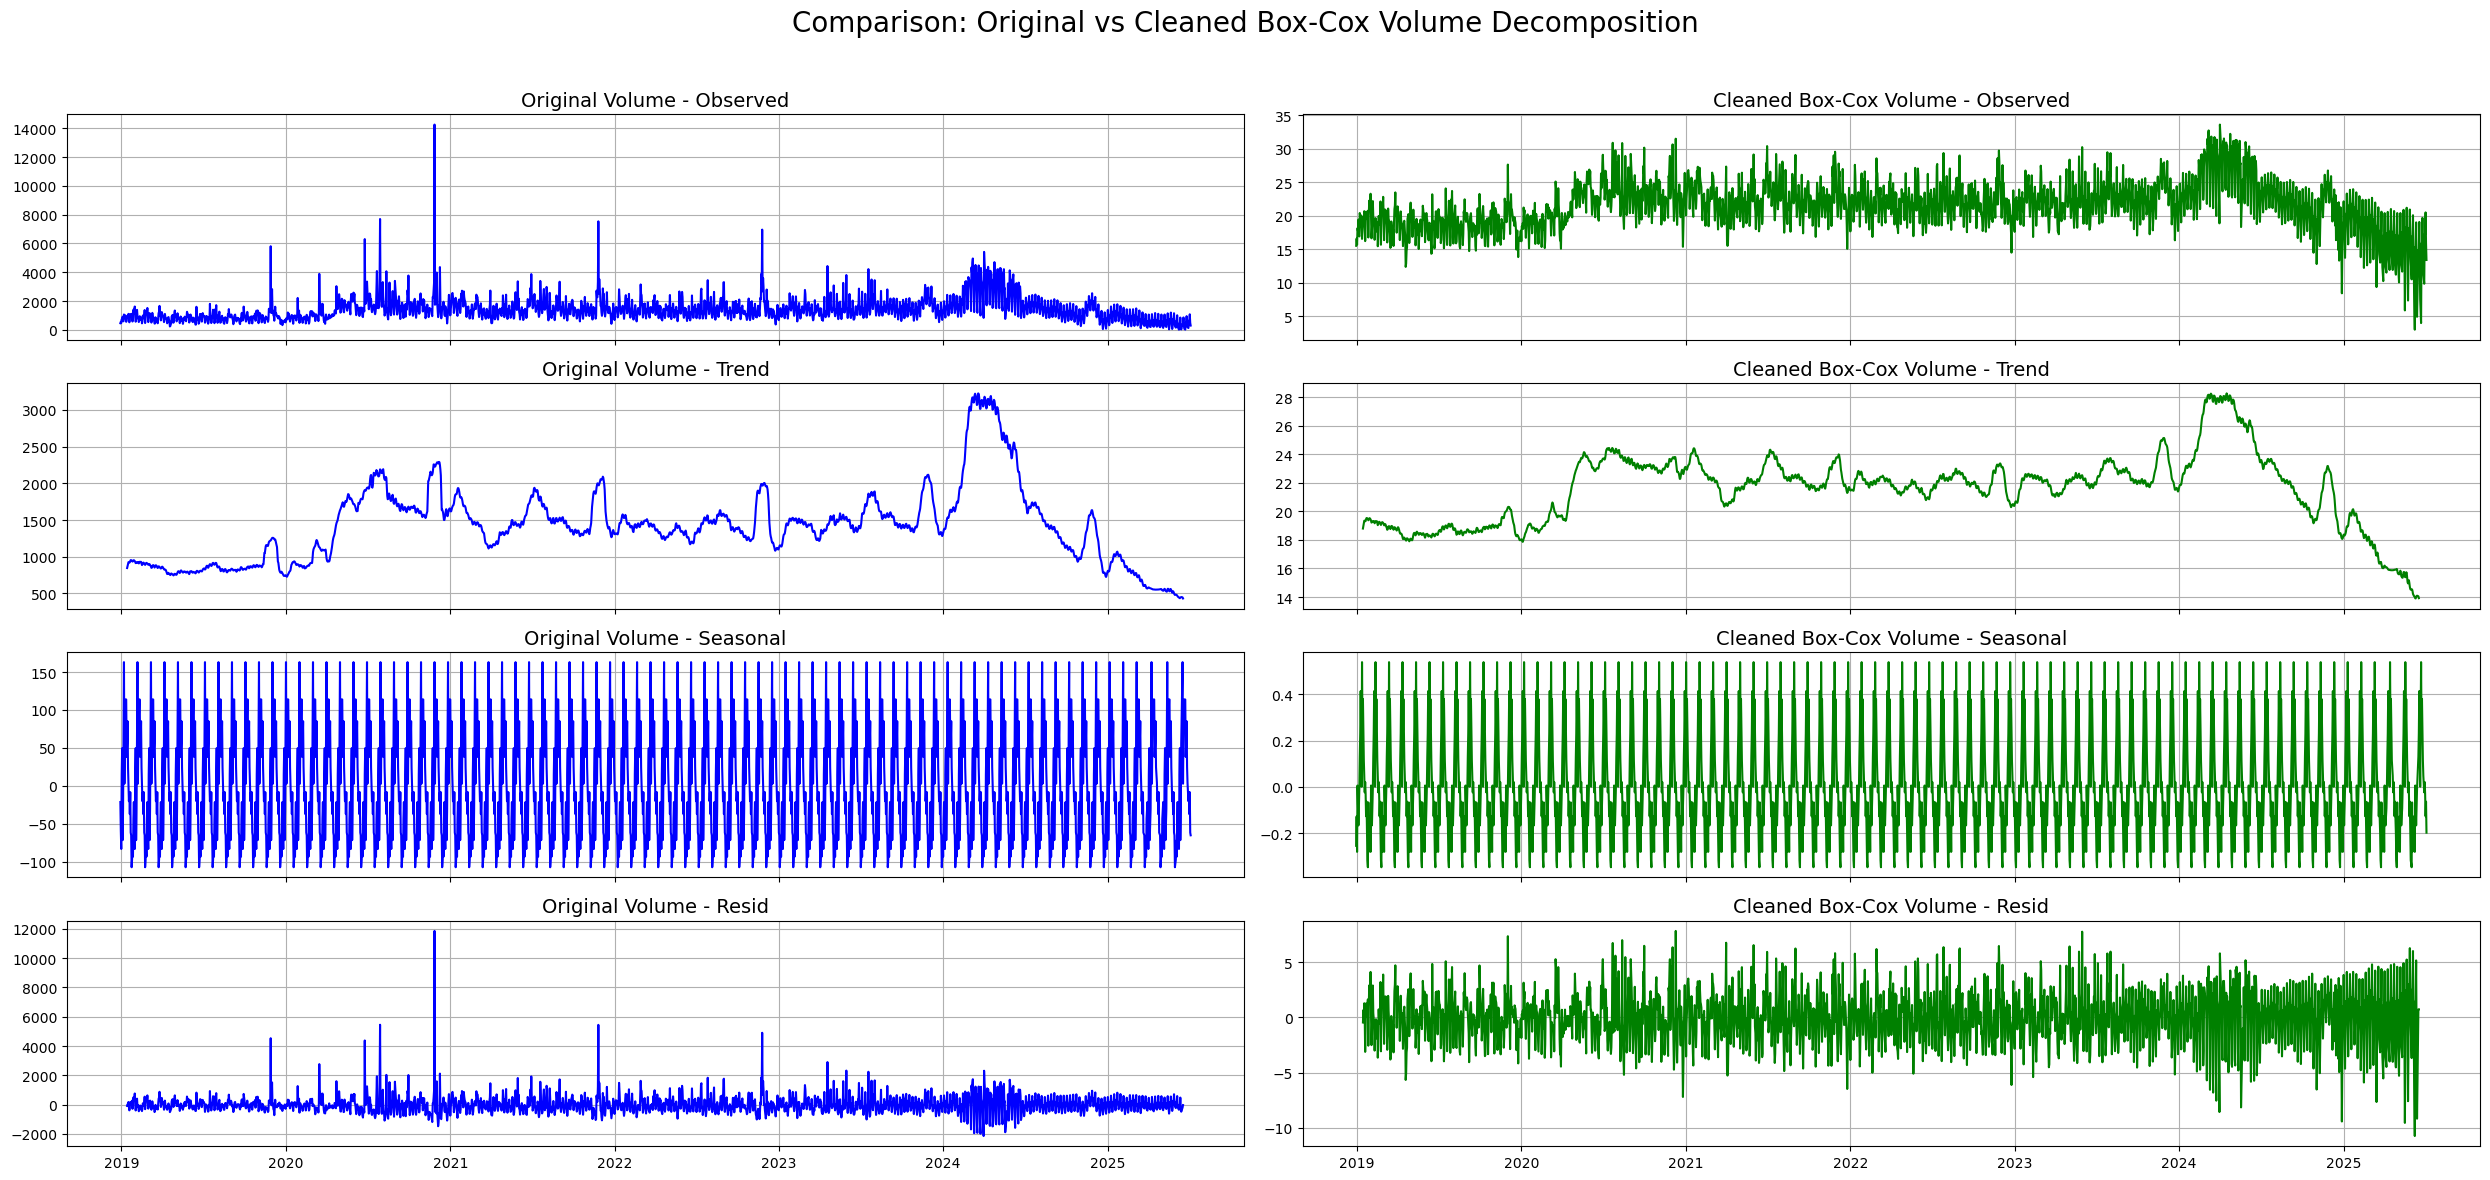

In [155]:
# Decompose original and cleaned Box-Cox series
decompose_original = seasonal_decompose(df['Volume'], model='additive', period=30)
decompose_cleaned = seasonal_decompose(df_clean['Volume_boxcox'], model='additive', period=30)

# Create figure
fig, axes = plt.subplots(4, 2, figsize=(25, 12), sharex=True)

# Titles for left and right columns
titles = ['Original Volume', 'Cleaned Box-Cox Volume']

# Plot original vs cleaned
for i, component in enumerate(['observed', 'trend', 'seasonal', 'resid']):
    # Original
    axes[i, 0].plot(getattr(decompose_original, component), color='blue')
    axes[i, 0].set_title(f'{titles[0]} - {component.capitalize()}', fontsize=14)
    axes[i, 0].grid(True)
    
    # Cleaned
    axes[i, 1].plot(getattr(decompose_cleaned, component), color='green')
    axes[i, 1].set_title(f'{titles[1]} - {component.capitalize()}', fontsize=14)
    axes[i, 1].grid(True)

plt.suptitle('Comparison: Original vs Cleaned Box-Cox Volume Decomposition', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [156]:
def compute_strength(decompose_result):
    trend = decompose_result.trend.dropna()
    seasonal = decompose_result.seasonal.dropna()
    resid = decompose_result.resid.dropna()
    observed = decompose_result.observed.dropna()
    
    # Trend strength
    trend_strength = 1 - (np.var(resid) / np.var(trend + resid))
    # Seasonal strength
    seasonal_strength = 1 - (np.var(resid) / np.var(seasonal + resid))
    
    return trend_strength, seasonal_strength

# Original
trend_strength_orig, seasonal_strength_orig = compute_strength(decompose_original)
# Cleaned Box-Cox
trend_strength_clean, seasonal_strength_clean = compute_strength(decompose_cleaned)

# Print comparison
print("Trend & Seasonal Strength Comparison:")
print(f"Original Volume -> Trend: {trend_strength_orig:.2f}, Seasonal: {seasonal_strength_orig:.2f}")
print(f"Cleaned Box-Cox Volume -> Trend: {trend_strength_clean:.2f}, Seasonal: {seasonal_strength_clean:.2f}")


Trend & Seasonal Strength Comparison:
Original Volume -> Trend: 0.44, Seasonal: 0.01
Cleaned Box-Cox Volume -> Trend: 0.55, Seasonal: 0.01


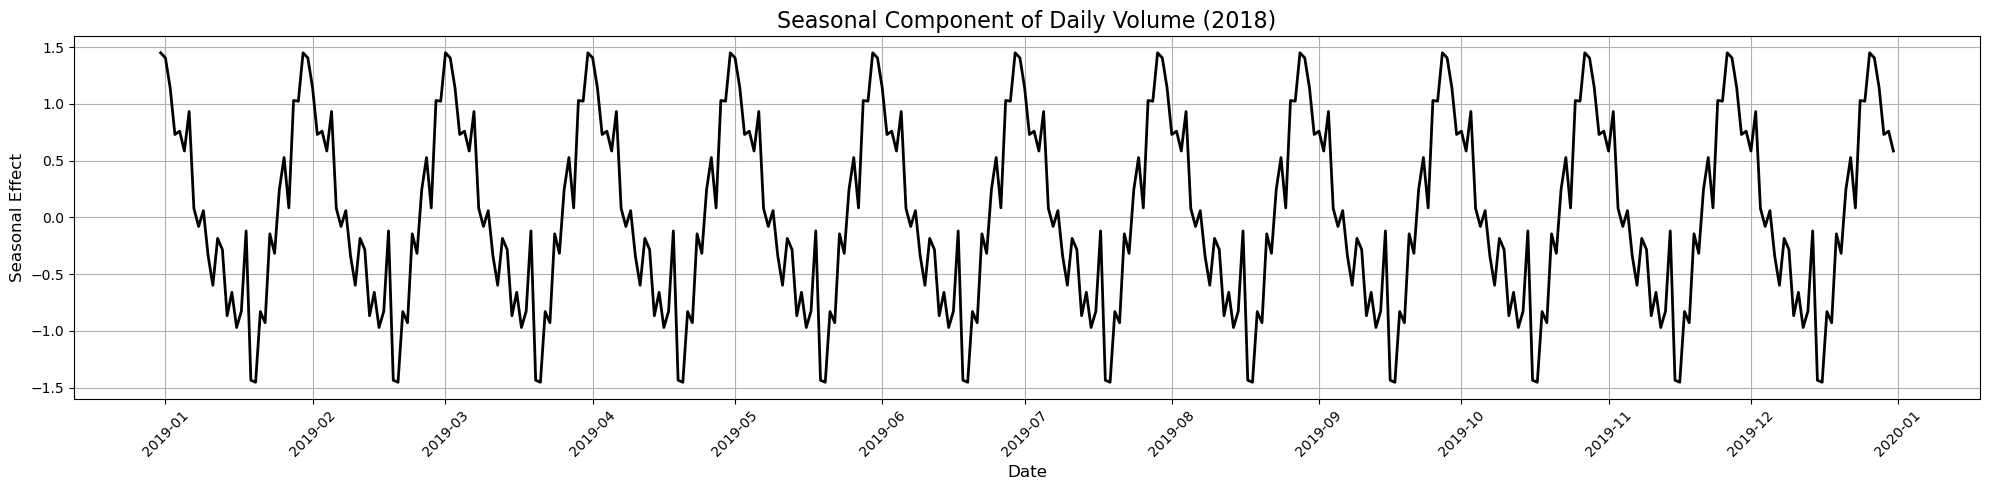

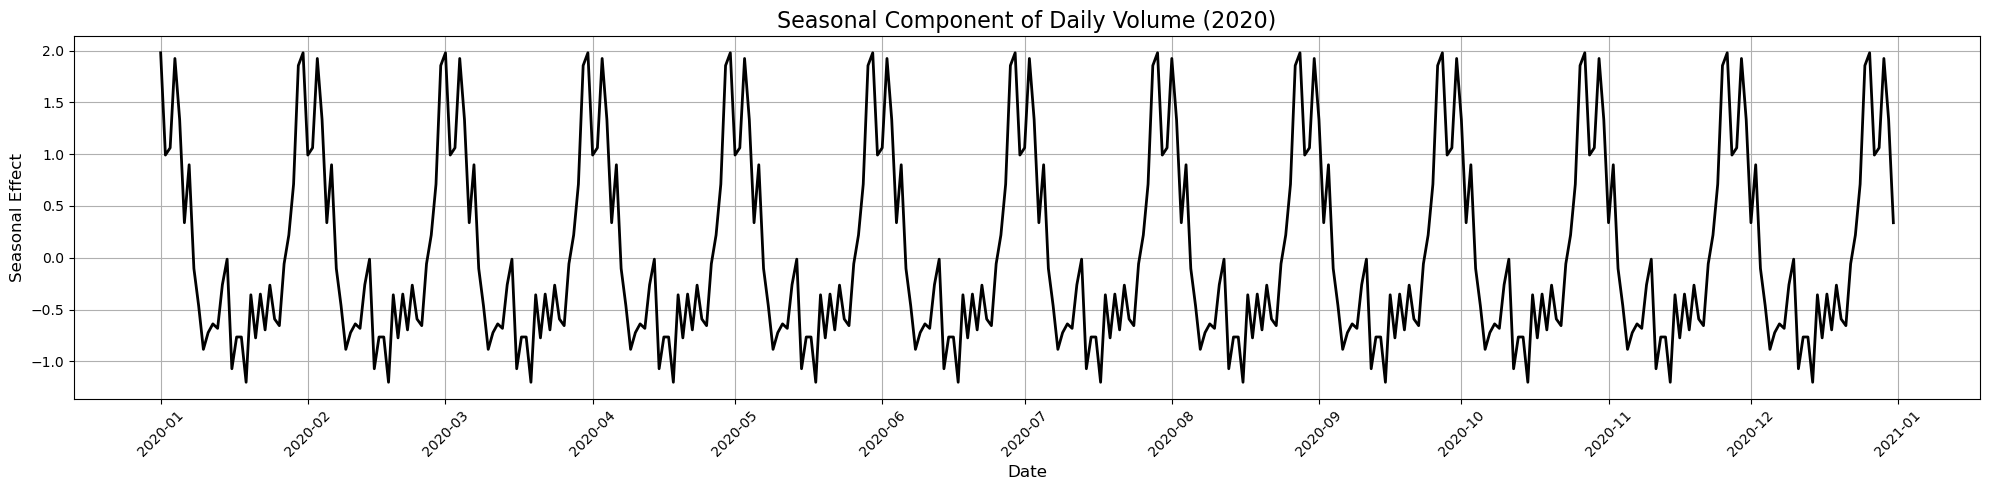

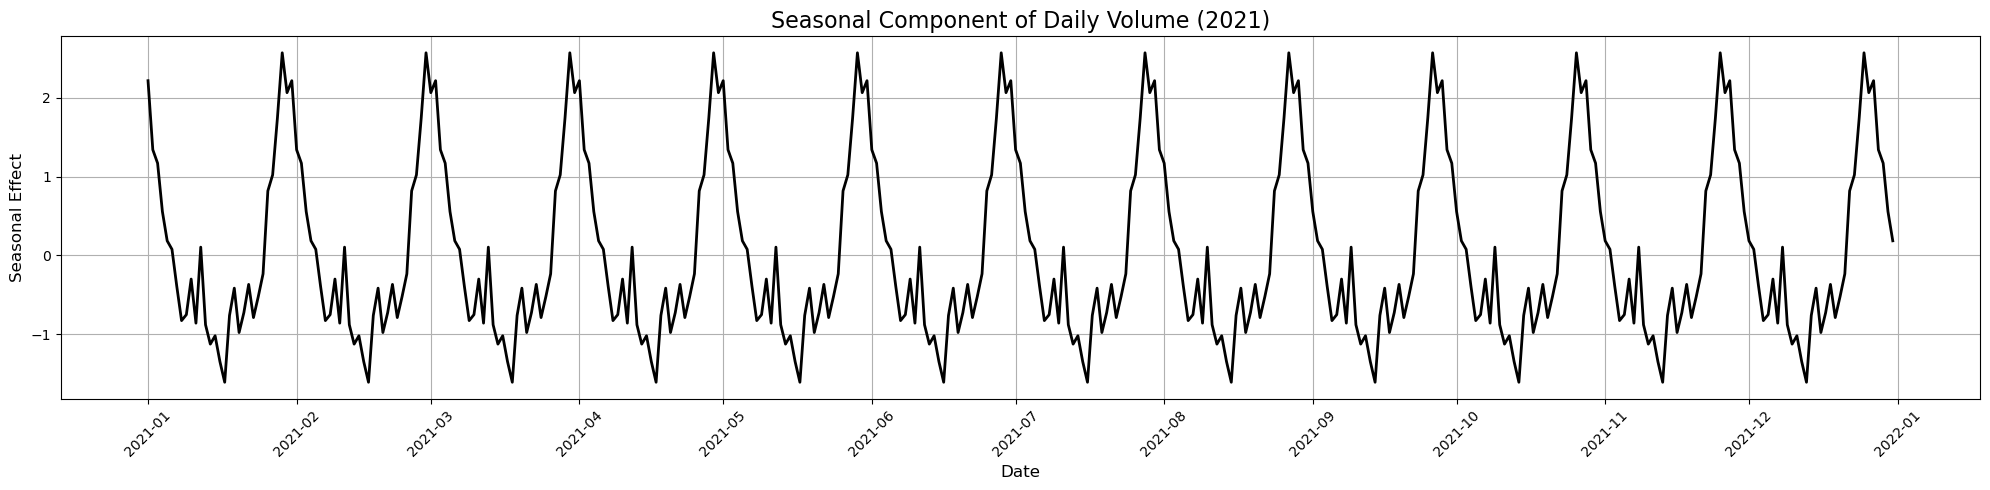

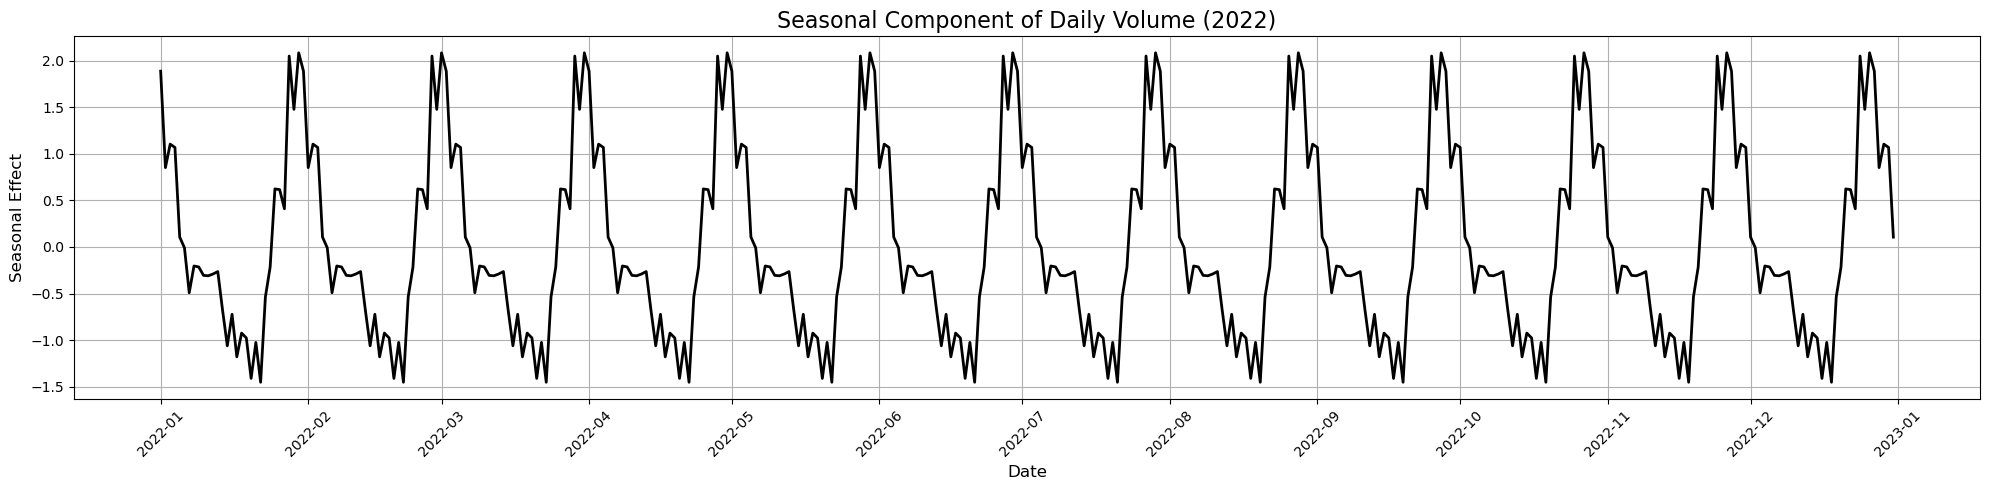

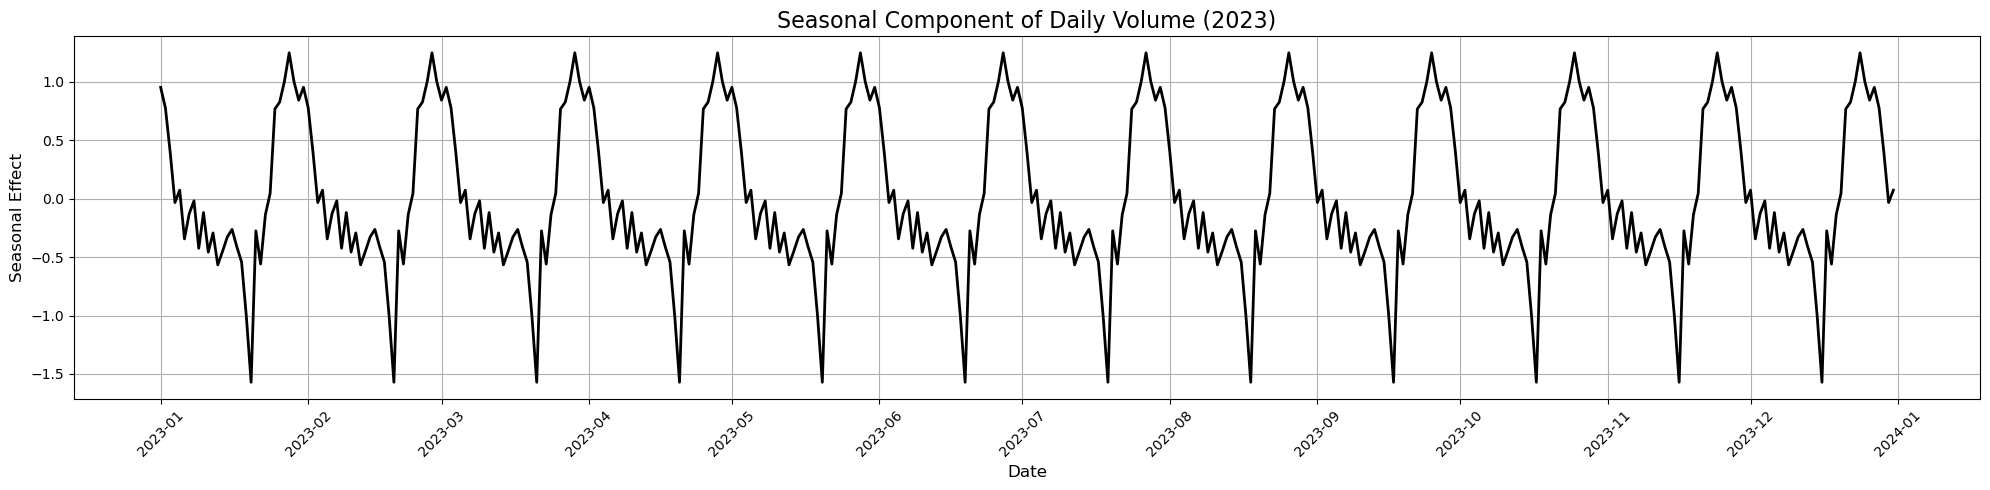

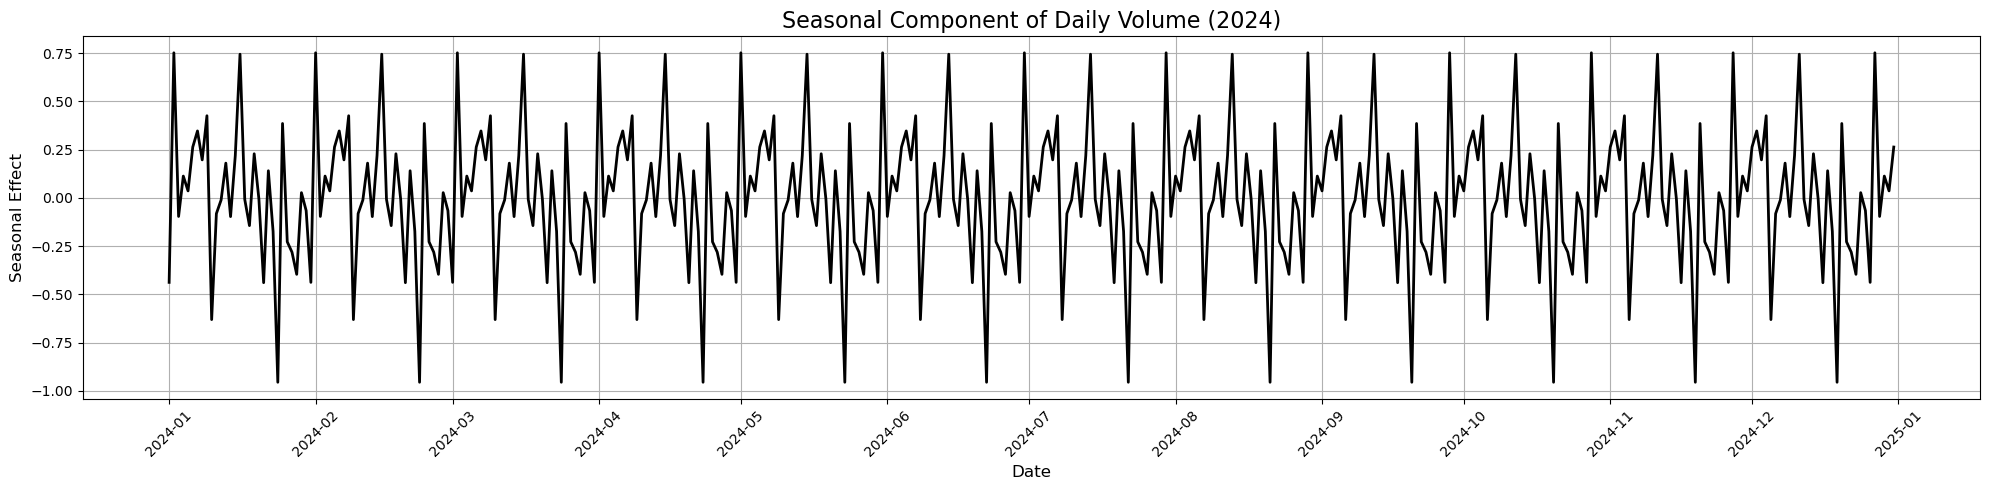

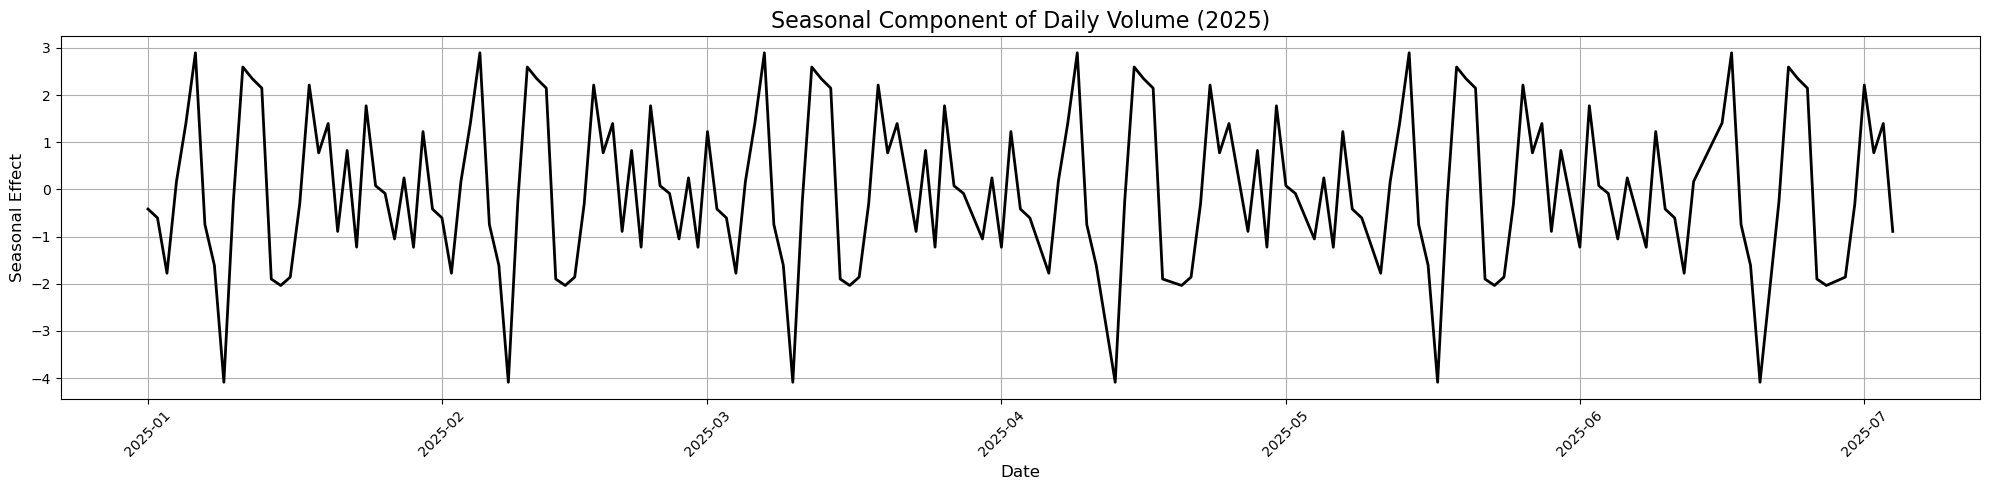

In [157]:
year_ranges = [
    ('2018-12-31', '2019-12-31'),
    ('2020-01-01', '2020-12-31'),
    ('2021-01-01', '2021-12-31'),
    ('2022-01-01', '2022-12-31'),
    ('2023-01-01', '2023-12-31'),
    ('2024-01-01', '2024-12-31'),
    ('2025-01-01', '2025-12-31')
]

# Loop through each year and plot seasonal component
for start_date, end_date in year_ranges:
    df_subset = df_clean.loc[start_date:end_date]
    
    if len(df_subset) < 30: 
        continue
    
    decompose_subset = seasonal_decompose(df_subset['Volume_boxcox'], model='additive', period=30)
    seasonal = decompose_subset.seasonal
    
    plt.figure(figsize=(20,5))
    plt.plot(seasonal, color='black', linewidth=2)
    plt.title(f'Seasonal Component of Daily Volume ({start_date[:4]})', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Seasonal Effect', fontsize=12)
    plt.grid(True)
    
    # Format x-axis for months
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

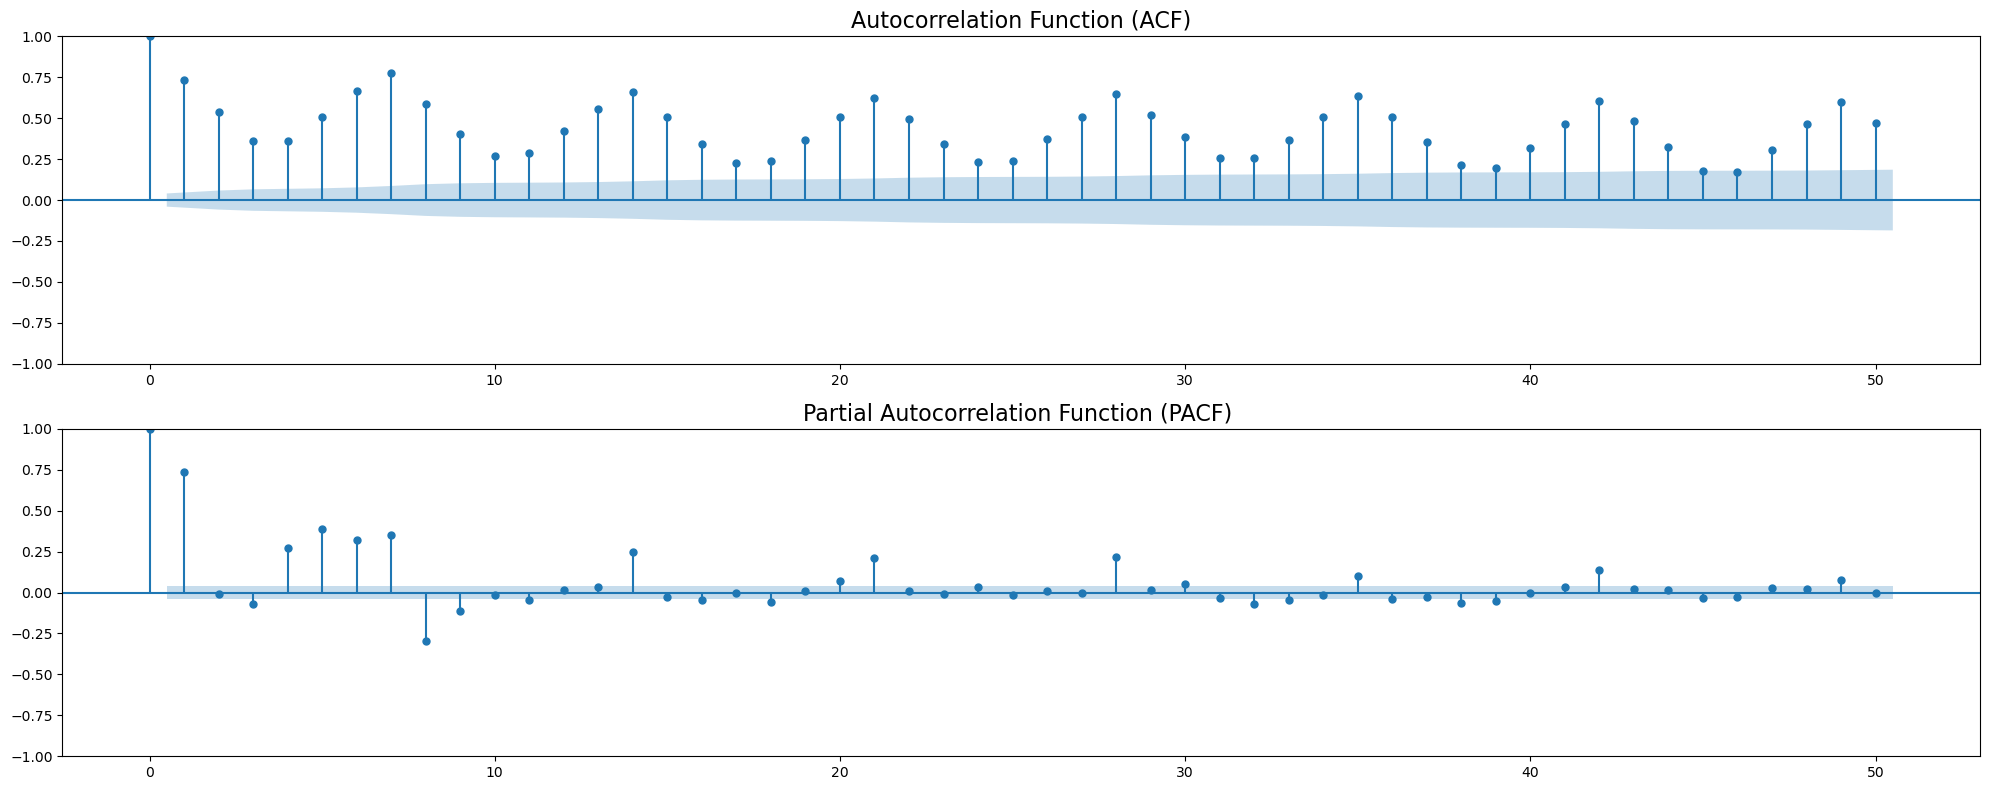

In [158]:
plt.figure(figsize=(20,8))

# ACF
plt.subplot(2,1,1)
plot_acf(df_clean, lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)', fontsize=16)

# PACF
plt.subplot(2,1,2)
plot_pacf(df_clean, lags=50, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation Function (PACF) ', fontsize=16)

plt.tight_layout()
plt.show()


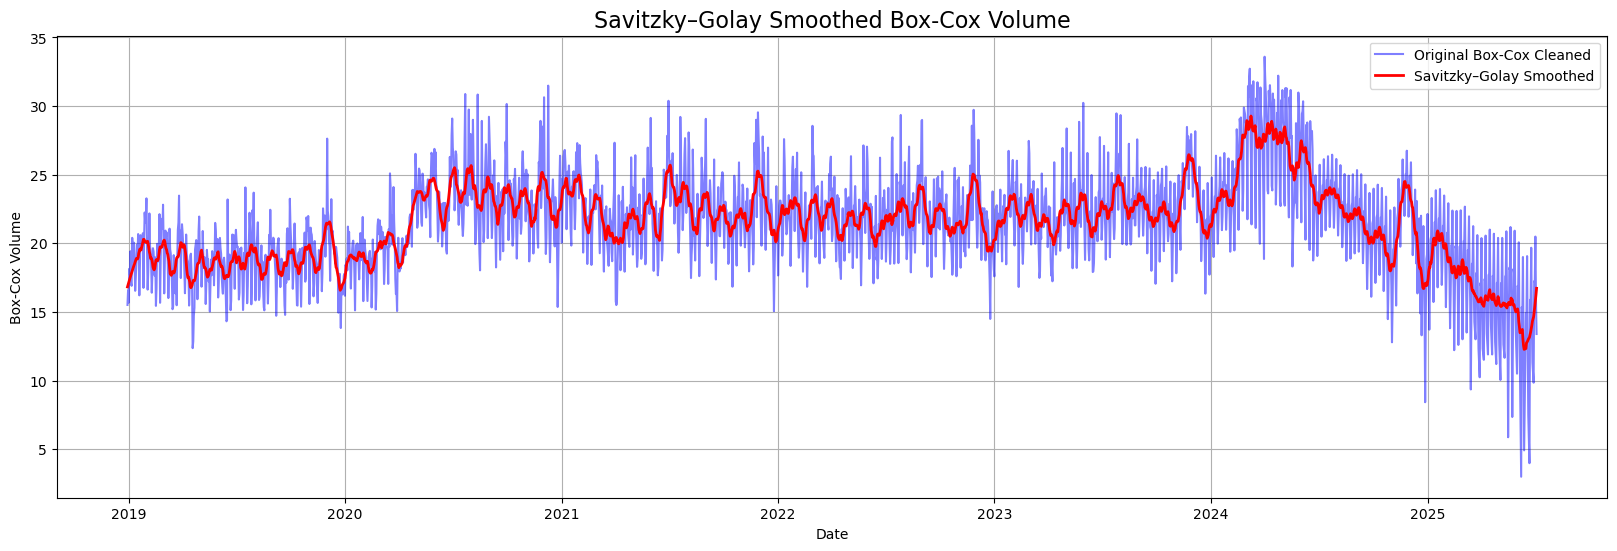

In [159]:
window_length = 31
polyorder = 2
# Apply Savitzky–Golay filter to the entire cleaned Box-Cox series
df_clean['Volume_boxcox_smooth'] = savgol_filter(df_clean['Volume_boxcox'], 
                                                 window_length=window_length, 
                                                 polyorder=polyorder)

# Plot smoothed vs original Box-Cox
plt.figure(figsize=(20,6))
plt.plot(df_clean['Volume_boxcox'], label='Original Box-Cox Cleaned', alpha=0.5, color='blue')
plt.plot(df_clean['Volume_boxcox_smooth'], label='Savitzky–Golay Smoothed', color='red', linewidth=2)
plt.title('Savitzky–Golay Smoothed Box-Cox Volume', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Box-Cox Volume')
plt.legend()
plt.grid(True)
plt.show()

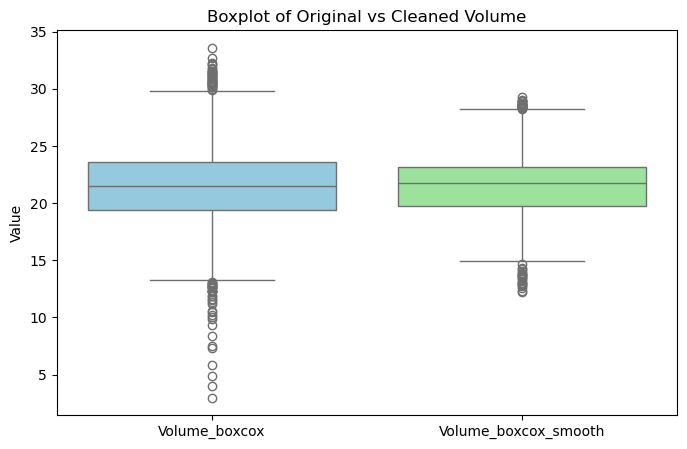

In [160]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_clean[['Volume_boxcox','Volume_boxcox_smooth']], palette=["skyblue","lightgreen"])
plt.title("Boxplot of Original vs Cleaned Volume")
plt.ylabel("Value")
plt.show()


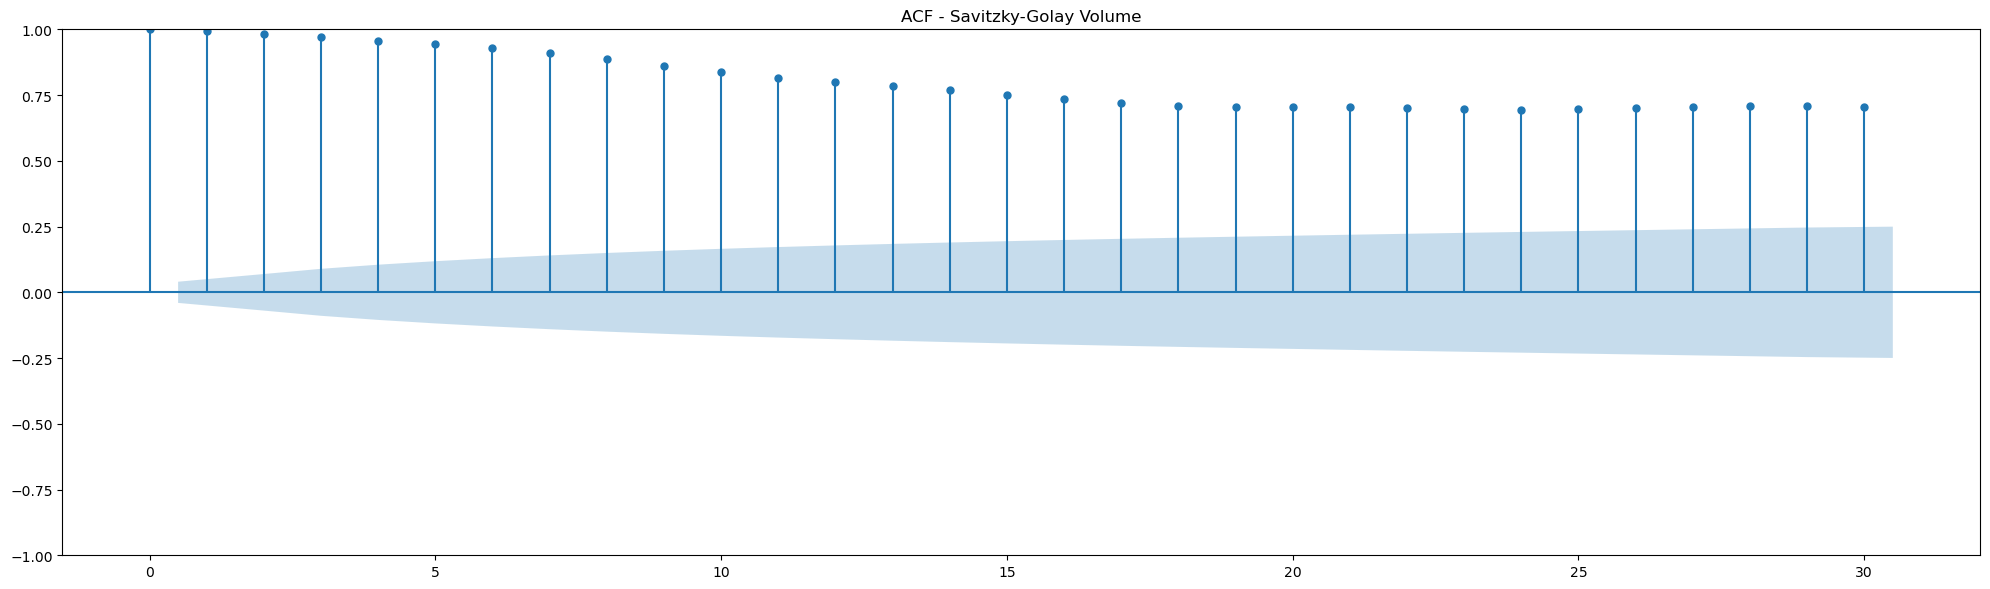

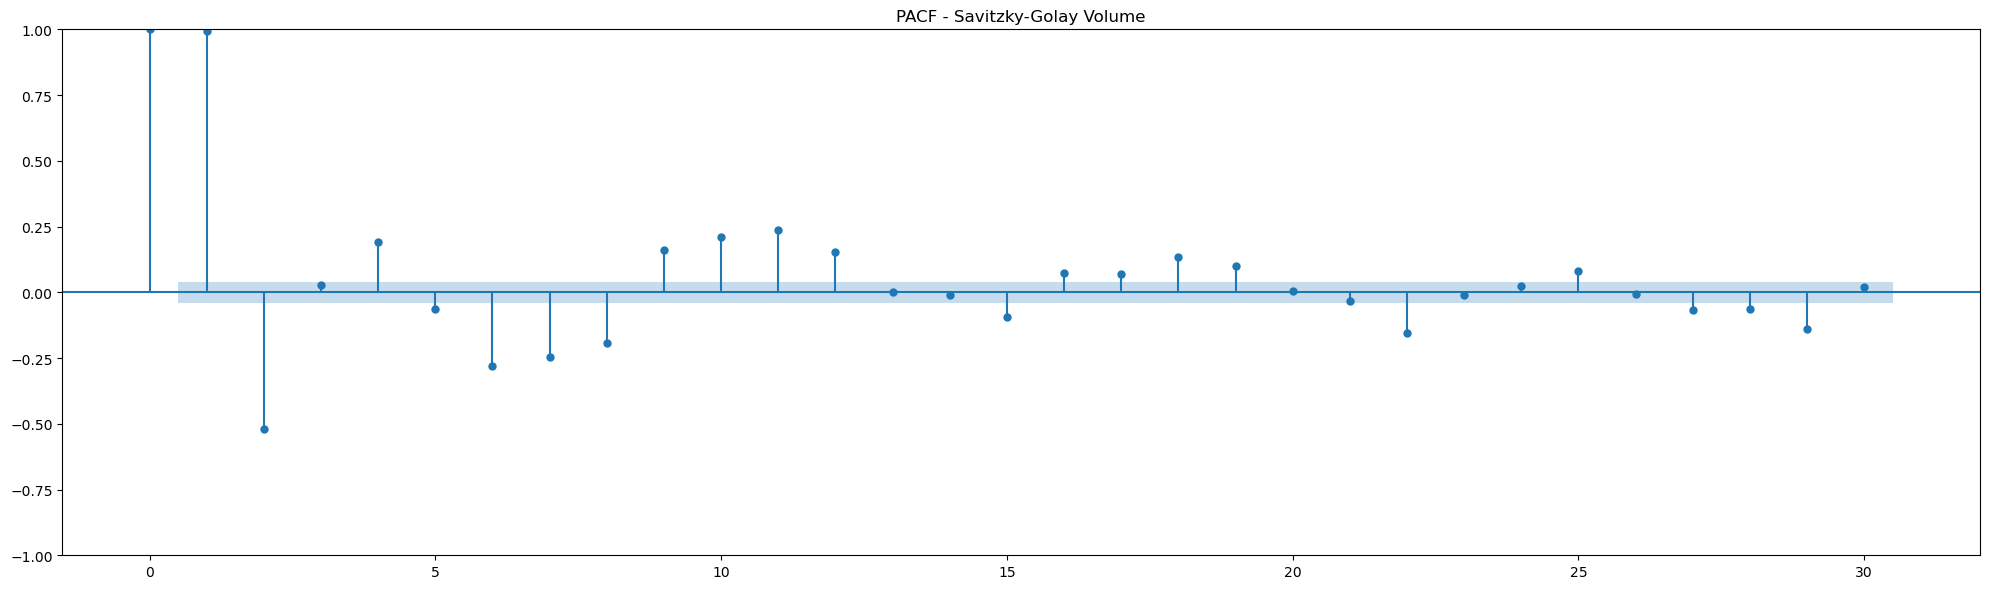

In [161]:
# --- ACF ---
plt.figure(figsize=(20,6))
plot_acf(df_clean['Volume_boxcox_smooth'], lags=30, ax=plt.gca())
plt.title("ACF - Savitzky-Golay Volume")
plt.tight_layout()
plt.show()

# --- PACF ---
plt.figure(figsize=(20,6))
plot_pacf(df_clean['Volume_boxcox_smooth'], lags=30, ax=plt.gca())
plt.title("PACF - Savitzky-Golay Volume")
plt.tight_layout()
plt.show()

#   EXPLORATORY DATA ANALYSIS

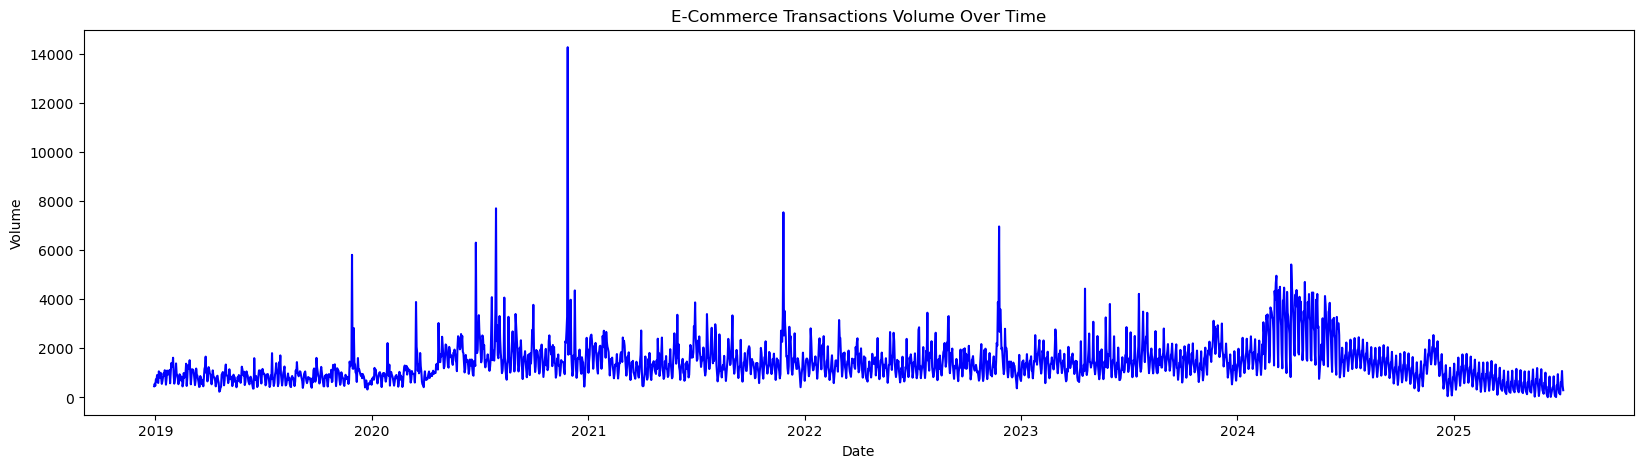

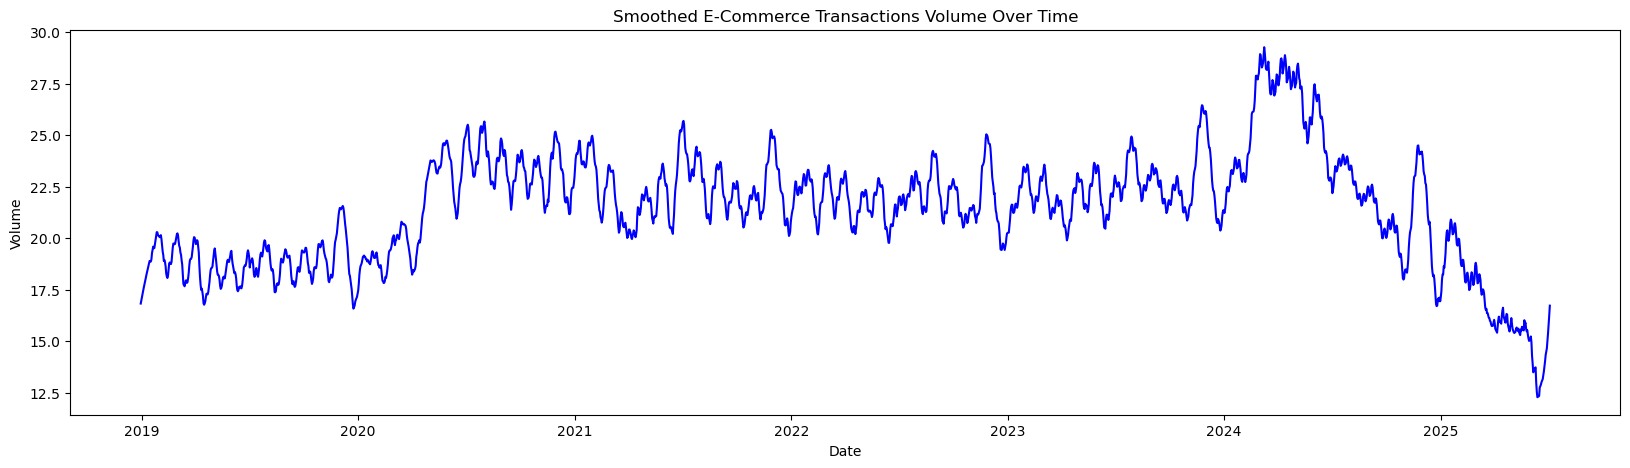

In [162]:
plt.figure(figsize=(20,5))
plt.plot(df['Volume'], color='blue')
plt.title('E-Commerce Transactions Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()


plt.figure(figsize=(20,5))
plt.plot(df_clean['Volume_boxcox_smooth'], color='blue')
plt.title('Smoothed E-Commerce Transactions Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

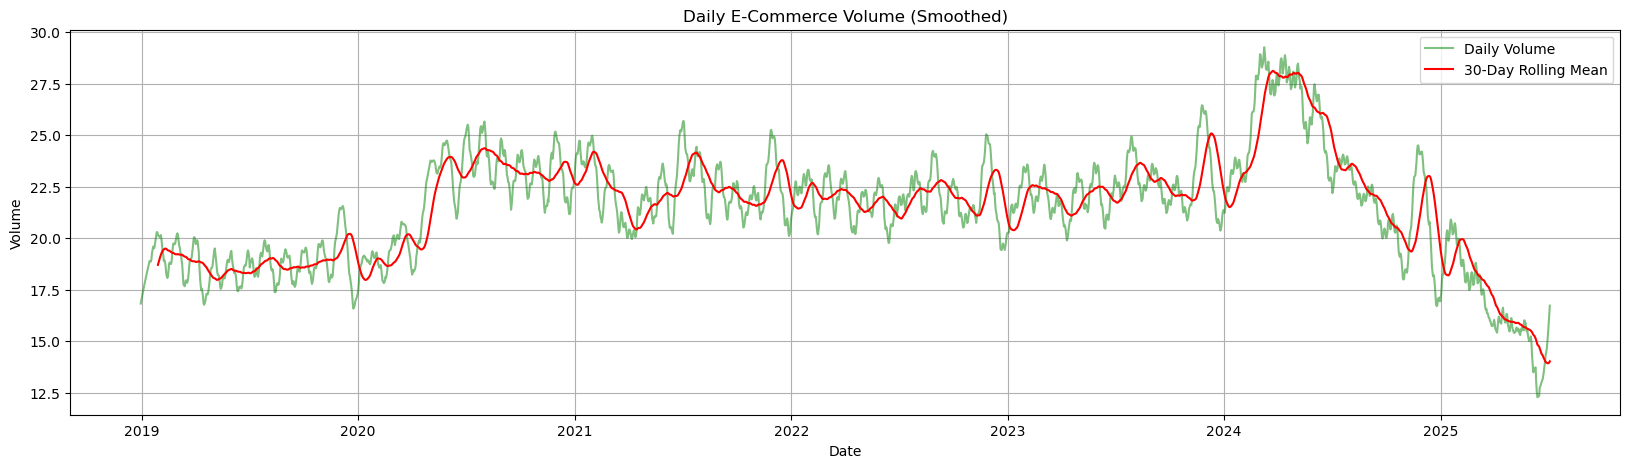

In [163]:
rolling_mean_daily = df_clean['Volume_boxcox_smooth'].rolling(window=30).mean()  # 30-day smoothing

plt.figure(figsize=(20,5))
plt.plot(df_clean['Volume_boxcox_smooth'], color='green', alpha=0.5, label='Daily Volume')
plt.plot(rolling_mean_daily, color='red', label='30-Day Rolling Mean')
plt.title('Daily E-Commerce Volume (Smoothed)')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

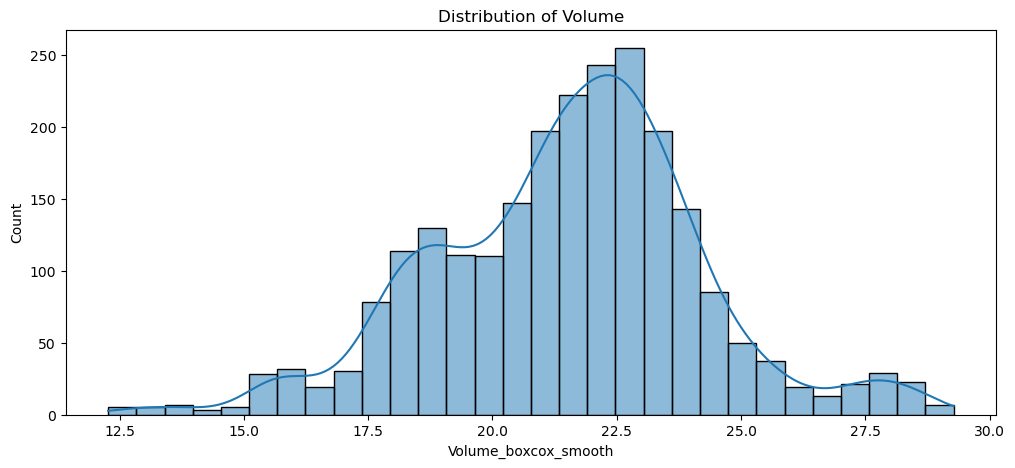

In [164]:
plt.figure(figsize=(12,5))
sns.histplot(df_clean['Volume_boxcox_smooth'], kde=True, bins=30)
plt.title('Distribution of Volume')
plt.show()


# FEATURE Engeneering

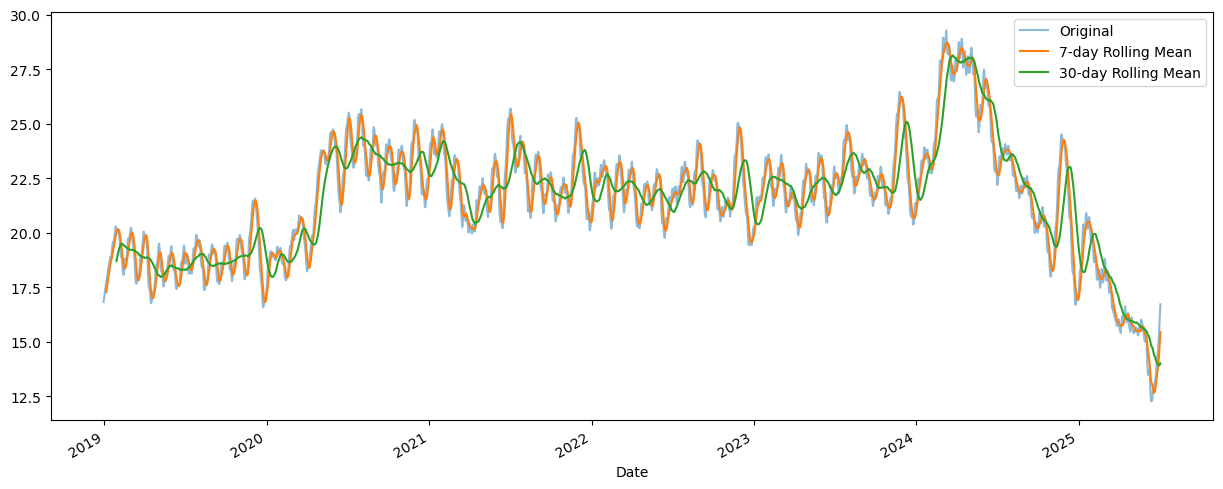

In [165]:
#desiding which rolling window captures the trends and which on dont 
df_clean['Volume_boxcox_smooth'].plot(figsize=(15,6), alpha=0.5, label="Original")
df_clean['Volume_boxcox_smooth'].rolling(7).mean().plot(label="7-day Rolling Mean")
df_clean['Volume_boxcox_smooth'].rolling(30).mean().plot(label="30-day Rolling Mean")
plt.legend()
plt.show()

In [166]:
# Make a copy for feature engineering
df_feat = df_clean[['Volume_boxcox_smooth']].copy()


# ---------------------------
#  Lag features
# ---------------------------
   
df_feat['lag_1'] = df_feat['Volume_boxcox_smooth'].shift(1)
df_feat['lag_2'] = df_feat['Volume_boxcox_smooth'].shift(1)


# ---------------------------
#  Drop initial rows with NaNs (from lags)
# ---------------------------
df_feat.dropna(inplace=True)

# ---------------------------
# Quick check
# ---------------------------
df_feat.head()


Volume_boxcox_smooth      lag_1      lag_2
Date                                                  
2018-12-31             16.977765  16.821507  16.821507
2019-01-01             17.131434  16.977765  16.977765
2019-01-02             17.282514  17.131434  17.131434
2019-01-03             17.431005  17.282514  17.282514
2019-01-04             17.576907  17.431005  17.431005

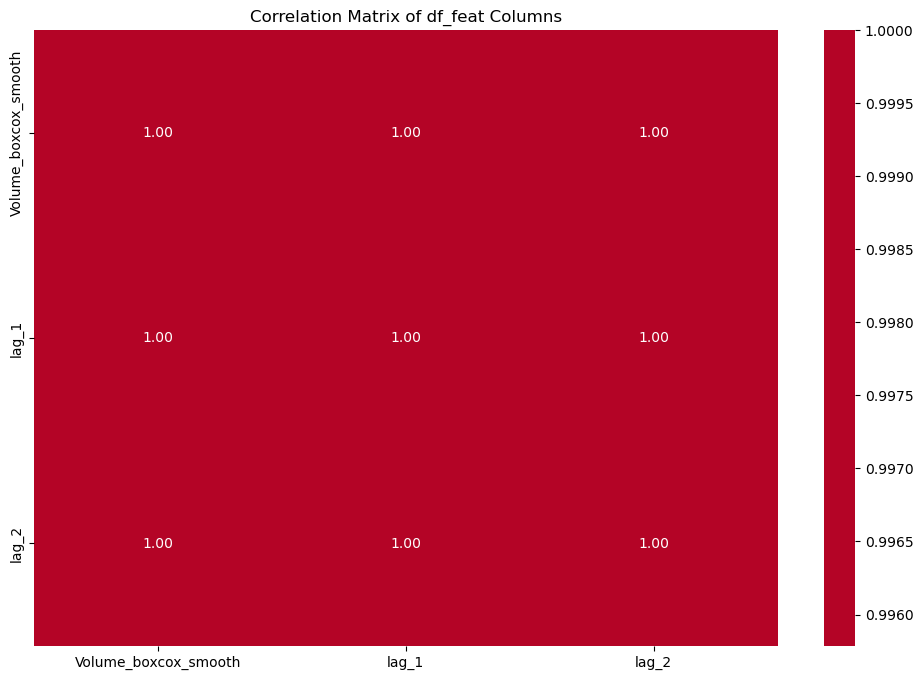

In [167]:
 # Correlation matrix
corr_matrix = df_feat.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix of df_feat Columns")
plt.show()

In [168]:
df_feat.columns

Index(['Volume_boxcox_smooth', 'lag_1', 'lag_2'], dtype='object')

In [169]:
df_feat.rename(columns={'Volume_boxcox_smooth': 'Volume_SG'}, inplace=True)

In [170]:
df_feat.head()

Volume_SG      lag_1      lag_2
Date                                       
2018-12-31  16.977765  16.821507  16.821507
2019-01-01  17.131434  16.977765  16.977765
2019-01-02  17.282514  17.131434  17.131434
2019-01-03  17.431005  17.282514  17.282514
2019-01-04  17.576907  17.431005  17.431005

In [171]:
# Save to CSV
df_feat.to_csv('denoised_volume.csv', index=True)

print("CSV saved with only top features.")
print(df_feat.head())

CSV saved with only top features.
            Volume_SG      lag_1      lag_2
Date                                       
2018-12-31  16.977765  16.821507  16.821507
2019-01-01  17.131434  16.977765  16.977765
2019-01-02  17.282514  17.131434  17.131434
2019-01-03  17.431005  17.282514  17.282514
2019-01-04  17.576907  17.431005  17.431005


In [172]:
# --- Separate features and target ---
features = [col for col in df_feat.columns if col != 'Volume_SG']
target = ['Volume_SG']


In [173]:
# --- Initialize scalers ---
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# --- Scale features and target separately ---
data_scaled_X = scaler_X.fit_transform(df_feat[features])
data_scaled_y = scaler_y.fit_transform(df_feat[target])

# --- Convert back to DataFrame for convenience ---
data_scaled = pd.DataFrame(data_scaled_X, columns=features, index=df_feat.index)
data_scaled['Volume_SG'] = data_scaled_y


In [174]:

# --- Split index for 80% train, 20% test ---
train_size = 0.8
split_index = int(len(data_scaled) * train_size)

# --- Split the scaled data ---
train = data_scaled.iloc[:split_index].copy()
test  = data_scaled.iloc[split_index:].copy()

# --- Exogenous features ---
exog_features = [col for col in data_scaled.columns if col != 'Volume_SG']
X_train = train[exog_features]
X_test  = test[exog_features]

# --- Target variable ---
y_train = train['Volume_SG']
y_test  = test['Volume_SG']

print("X_train shape:", X_train.shape)  # (len(train), number of features)
print("X_test shape:", X_test.shape)    # (test, number of features)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1891, 2)
X_test shape: (473, 2)
y_train shape: (1891,)
y_test shape: (473,)


# ARIMA

In [175]:
'''
p = d = q = range(0, 4)
seasonal_p = seasonal_d = seasonal_q = range(0, 2)
seasonal_period = 7 

param_grid = list(itertools.product(p, [1], q))
seasonal_grid = list(itertools.product(seasonal_p, seasonal_d, seasonal_q, [seasonal_period]))

results = []
for order in param_grid:
    for seasonal_order in seasonal_grid:
        try:
            model = SARIMAX(train['Value'], exog=exog_train,
                            order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            result = model.fit(disp=False)
            results.append({
                'order': order,
                'seasonal_order': seasonal_order,
                'AIC': result.aic,
                'BIC': result.bic
            })
        except Exception as e:
            print(f"Failed for order={order}, seasonal_order={seasonal_order} | Error: {e}")

df_results = pd.DataFrame(results)
best_model = df_results.sort_values('AIC').iloc[0]
print(best_model)'''

'\np = d = q = range(0, 4)\nseasonal_p = seasonal_d = seasonal_q = range(0, 2)\nseasonal_period = 7 \n\nparam_grid = list(itertools.product(p, [1], q))\nseasonal_grid = list(itertools.product(seasonal_p, seasonal_d, seasonal_q, [seasonal_period]))\n\nresults = []\nfor order in param_grid:\n    for seasonal_order in seasonal_grid:\n        try:\n            model = SARIMAX(train[\'Value\'], exog=exog_train,\n                            order=order, seasonal_order=seasonal_order,\n                            enforce_stationarity=False,\n                            enforce_invertibility=False)\n            result = model.fit(disp=False)\n            results.append({\n                \'order\': order,\n                \'seasonal_order\': seasonal_order,\n                \'AIC\': result.aic,\n                \'BIC\': result.bic\n            })\n        except Exception as e:\n            print(f"Failed for order={order}, seasonal_order={seasonal_order} | Error: {e}")\n\ndf_results = pd.Data

In [176]:
arimax_model = SARIMAX(
    y_train,
    exog=X_train,
    order=(3,1,4),
    seasonal_order=(0,0,0,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

arimax_result = arimax_model.fit()
print(arimax_result.summary())


                               SARIMAX Results                                
Dep. Variable:              Volume_SG   No. Observations:                 1891
Model:               SARIMAX(3, 1, 4)   Log Likelihood                6673.718
Date:                Tue, 16 Sep 2025   AIC                         -13327.435
Time:                        00:19:40   BIC                         -13272.019
Sample:                    12-31-2018   HQIC                        -13307.026
                         - 03-04-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
lag_1          0.4530      0.007     64.392      0.000       0.439       0.467
lag_2          0.4530      0.007     64.392      0.000       0.439       0.467
ar.L1          0.4616      0.045     10.263      0.0

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
lag_1          0.4530      0.007     64.392      0.000       0.439       0.467
lag_2          0.4530      0.007     64.392      0.000       0.439       0.467
ar.L1          0.4616      0.045     10.263      0.000       0.373       0.550
ar.L2         -0.0233      0.056     -0.416      0.677      -0.133       0.086
ar.L3         -0.7857      0.045    -17.495      0.000      -0.874      -0.698
ma.L1         -0.7044      0.054    -13.091      0.000      -0.810      -0.599
ma.L2          0.0961      0.057      1.672      0.094      -0.017       0.209
ma.L3          0.9401      0.048     19.669      0.000       0.846       1.034
ma.L4         -0.3279      0.029    -11.490      0.000      -0.384      -0.272
sigma2       4.18e-05   1.31e-06     31.881      0.000    3.92e-05    4.44e-05


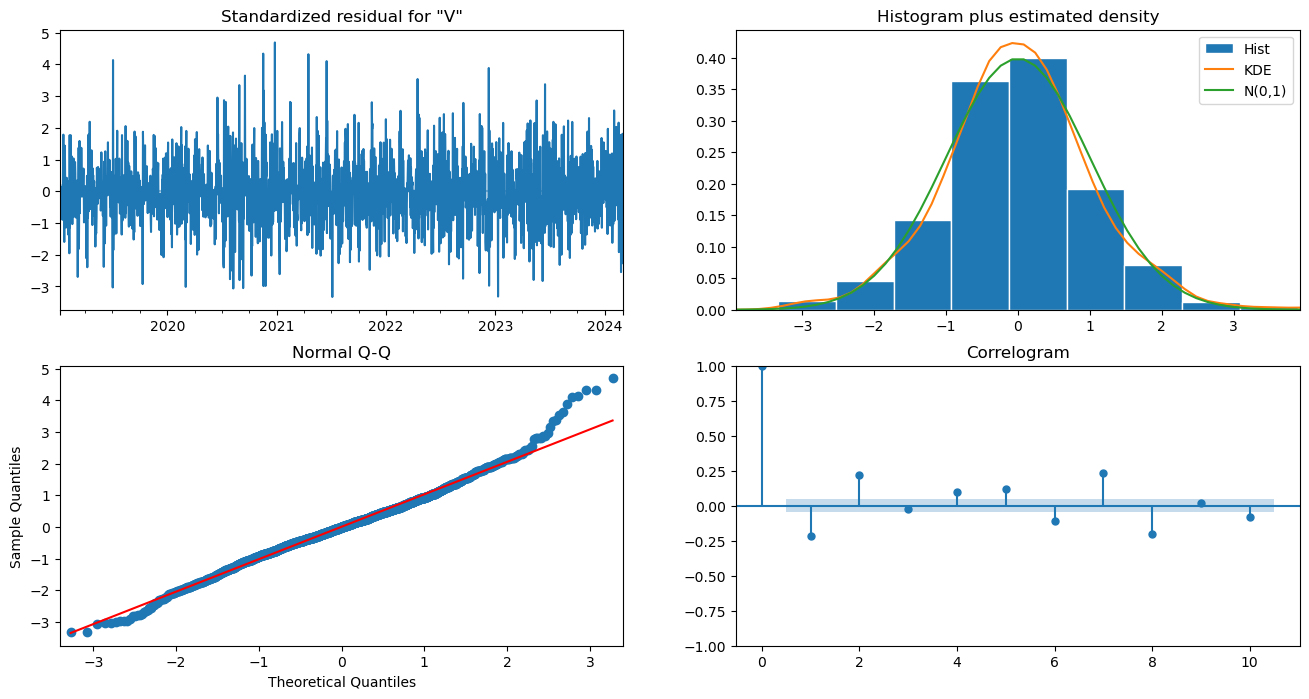

In [177]:

print(arimax_result.summary().tables[1])
arimax_result.plot_diagnostics(figsize=(16, 8))
plt.show()


In [178]:

forecast = arimax_result.get_forecast(steps=len(X_test), exog=X_test)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, forecast_values))
mae = mean_absolute_error(y_test, forecast_values)
r2 = r2_score(y_test, forecast_values)

print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")


RMSE: 0.0474, MAE: 0.0407, R²: 0.9651


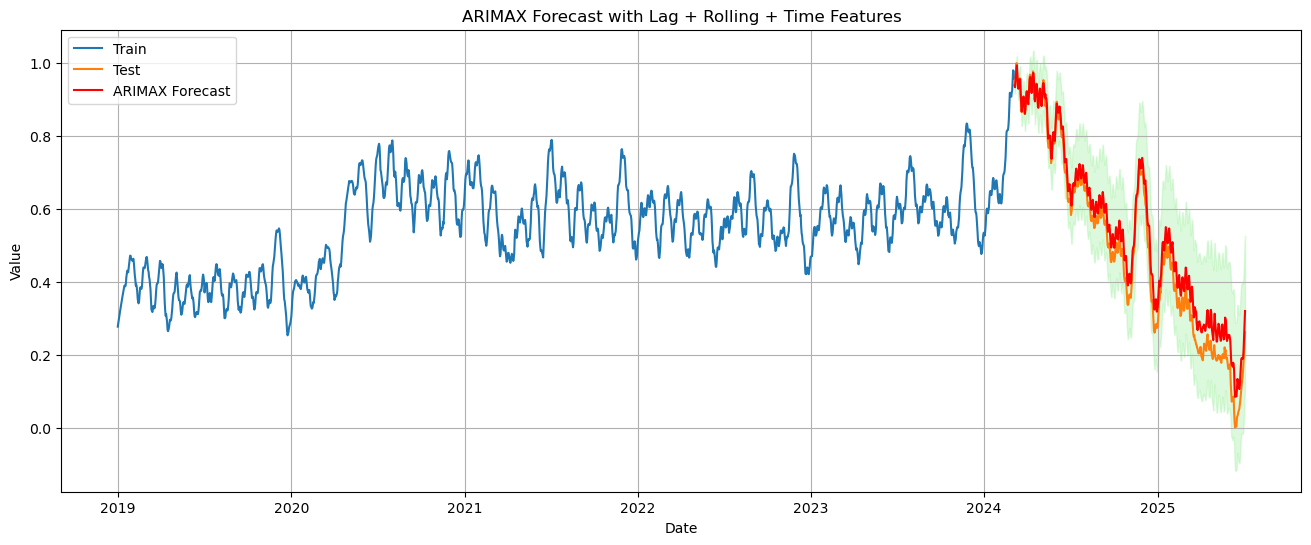

In [179]:
plt.figure(figsize=(16,6))
plt.plot(train.index, train['Volume_SG'], label='Train')
plt.plot(test.index, test['Volume_SG'], label='Test')
plt.plot(test.index, forecast_values, color='red', label='ARIMAX Forecast')
plt.fill_between(test.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='lightgreen', alpha=0.3)
plt.title("ARIMAX Forecast with Lag + Rolling + Time Features")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


# LSTM

In [180]:
df_feat.columns

Index(['Volume_SG', 'lag_1', 'lag_2'], dtype='object')

In [181]:

def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, 1:])   # Exogenous features 
        y.append(data[i+seq_length, 0])      # Target 
    return np.array(X), np.array(y)

seq_length = 7

# Create sequences
X_train, y_train = create_sequences(train.values, seq_length)
X_test, y_test   = create_sequences(test.values, seq_length)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)




Train shape: (1884, 7, 2) (1884,)
Test shape: (466, 7, 2) (466,)


In [182]:
#HELPING FUCTIONS 

def plot_history(histories, names):
    plt.figure(figsize=(18,6))
    for i, history in enumerate(histories):
        plt.plot(history.history['loss'], label=f'{names[i]} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{names[i]} Val Loss', linestyle='--')
    plt.title('Deep Learning Model Training History (MSE Loss)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
def evaluate_model(model, X_test, y_test):
    pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    return rmse, mae, r2

# EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',    
    patience=5,            
    restore_best_weights=True 
)



#parameters
Epochs = 50
Batch_size=64
input_shape = (X_train.shape[1], X_train.shape[2])

In [183]:
def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(64, activation="tanh", return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer="adam",  loss='mse', metrics=['mae'])
    return model

lstm_model = build_lstm(input_shape)
history_lstm = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test),
                              epochs=Epochs, batch_size=Batch_size, callbacks=[early_stop],verbose=1)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1184 - mae: 0.2810 - val_loss: 0.0113 - val_mae: 0.0859
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - mae: 0.0663 - val_loss: 0.0054 - val_mae: 0.0612
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 - mae: 0.0595 - val_loss: 0.0042 - val_mae: 0.0540
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 - mae: 0.0589 - val_loss: 0.0033 - val_mae: 0.0473
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054 - mae: 0.0576 - val_loss: 0.0027 - val_mae: 0.0425
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - mae: 0.0557 - val_loss: 0.0021 - val_mae: 0.0369
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - mae: 0.0518 - val_loss: 0.0020 - val_mae: 0.0357
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - mae: 0.0549 - val_loss: 0.0017 - val_mae: 0.0333
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mae:

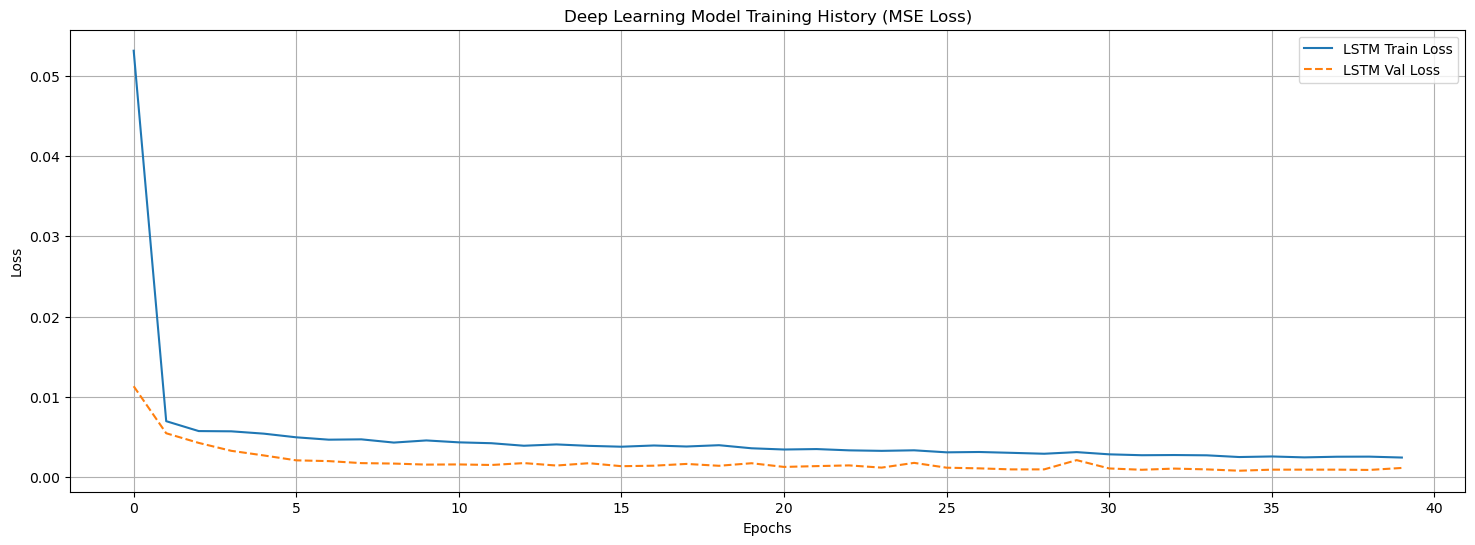

In [184]:
# Call the function
plot_history([history_lstm], ['LSTM'])

In [185]:
rmse_lstm, mae_lstm, r2_lstm = evaluate_model(lstm_model, X_test, y_test)
print(f"LSTM -> RMSE: {rmse_lstm:.4f}, MAE: {mae_lstm:.4f}, R2: {r2_lstm:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
LSTM -> RMSE: 0.0277, MAE: 0.0225, R2: 0.9877


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


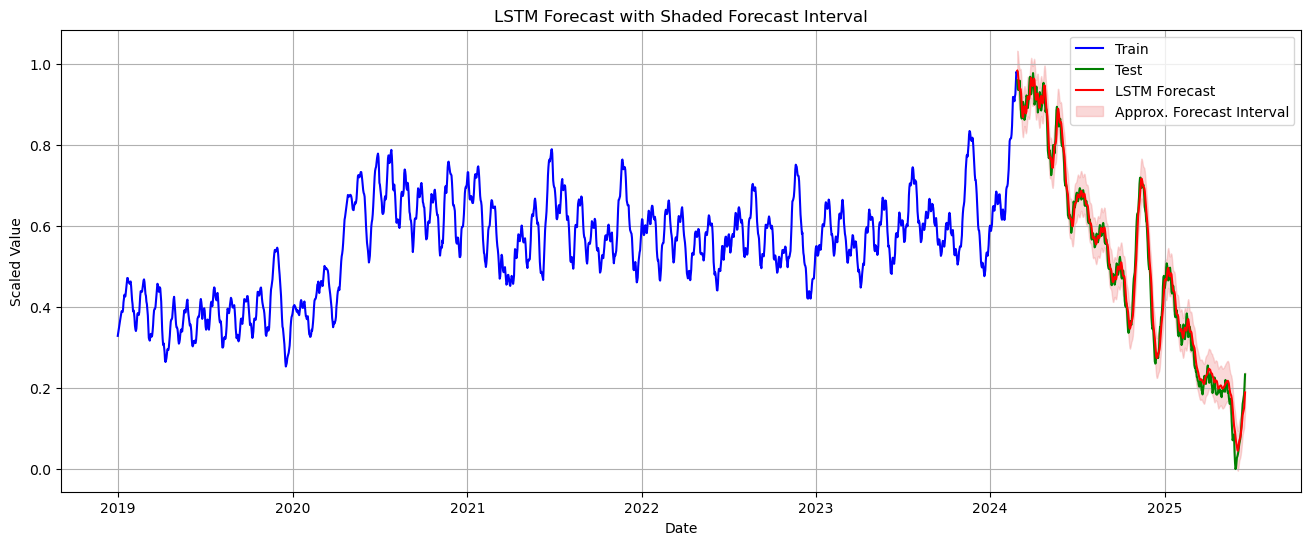

In [186]:
# Predict on test set
y_pred_lstm = lstm_model.predict(X_test).flatten()

# Compute residuals on train for approximate uncertainty
residuals = y_train - lstm_model.predict(X_train).flatten()
rolling_std = np.std(residuals)

# Upper and lower bounds
upper_bound = y_pred_lstm + 2*rolling_std
lower_bound = y_pred_lstm - 2*rolling_std

# Plot
plt.figure(figsize=(16,6))
plt.plot(df_feat.index[:len(y_train)], y_train, label='Train', color='blue')
plt.plot(df_feat.index[len(y_train):len(y_train)+len(y_test)], y_test, label='Test', color='green')
plt.plot(df_feat.index[len(y_train):len(y_train)+len(y_test)], y_pred_lstm, label='LSTM Forecast', color='red')
plt.fill_between(
    df_feat.index[len(y_train):len(y_train)+len(y_test)],
    lower_bound,
    upper_bound,
    color='lightcoral',
    alpha=0.3,
    label='Approx. Forecast Interval'
)
plt.title("LSTM Forecast with Shaded Forecast Interval")
plt.xlabel("Date")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)
plt.show()

In [187]:
# Get top 5 predictions and actuals
top5_actual = y_test[:5]
top5_pred   = y_pred_lstm[:5]

# Use the correct scaler for inverse transform
top5_actual_orig = scaler_y.inverse_transform(top5_actual.reshape(-1,1)).flatten()
top5_pred_orig   = scaler_y.inverse_transform(top5_pred.reshape(-1,1)).flatten()

# Print nicely
print("Top 5 Actual vs Predicted Values (LSTM)")
print("------------------------------------------------------")
for i in range(5):
    print(f"Actual   : {top5_actual_orig[i]:.2f} | Predicted : {top5_pred_orig[i]:.2f}")


Top 5 Actual vs Predicted Values (LSTM)
------------------------------------------------------
Actual   : 28.59 | Predicted : 28.99
Actual   : 28.22 | Predicted : 28.95
Actual   : 28.18 | Predicted : 28.74
Actual   : 28.18 | Predicted : 28.48
Actual   : 28.33 | Predicted : 28.26


# GRU

In [188]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam

def build_gru(input_shape):
    model = Sequential()
    model.add(GRU(128, 
                  activation='tanh', 
                  return_sequences=True, 
                  recurrent_dropout=0.2, 
                  input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(GRU(64, activation='tanh', recurrent_dropout=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Build and train the GRU model
gru_model = build_gru(input_shape=X_train.shape[1:])

history_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=Epochs,
    batch_size=Batch_size,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/50
30/30 - 4s - 121ms/step - loss: 0.0442 - mae: 0.1494 - val_loss: 0.0060 - val_mae: 0.0661
Epoch 2/50
30/30 - 0s - 9ms/step - loss: 0.0070 - mae: 0.0668 - val_loss: 0.0029 - val_mae: 0.0446
Epoch 3/50
30/30 - 0s - 9ms/step - loss: 0.0052 - mae: 0.0571 - val_loss: 0.0022 - val_mae: 0.0384
Epoch 4/50
30/30 - 0s - 9ms/step - loss: 0.0050 - mae: 0.0552 - val_loss: 0.0013 - val_mae: 0.0296
Epoch 5/50
30/30 - 0s - 11ms/step - loss: 0.0045 - mae: 0.0523 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 6/50
30/30 - 0s - 10ms/step - loss: 0.0042 - mae: 0.0507 - val_loss: 7.7896e-04 - val_mae: 0.0223
Epoch 7/50
30/30 - 0s - 9ms/step - loss: 0.0041 - mae: 0.0497 - val_loss: 7.2912e-04 - val_mae: 0.0214
Epoch 8/50
30/30 - 0s - 9ms/step - loss: 0.0039 - mae: 0.0483 - val_loss: 6.9896e-04 - val_mae: 0.0209
Epoch 9/50
30/30 - 0s - 9ms/step - loss: 0.0038 - mae: 0.0481 - val_loss: 7.3092e-04 - val_mae: 0.0220
Epoch 10/50
30/30 - 0s - 9ms/step - loss: 0.0035 - mae: 0.0461 - val_loss: 9.4714e-04 - v

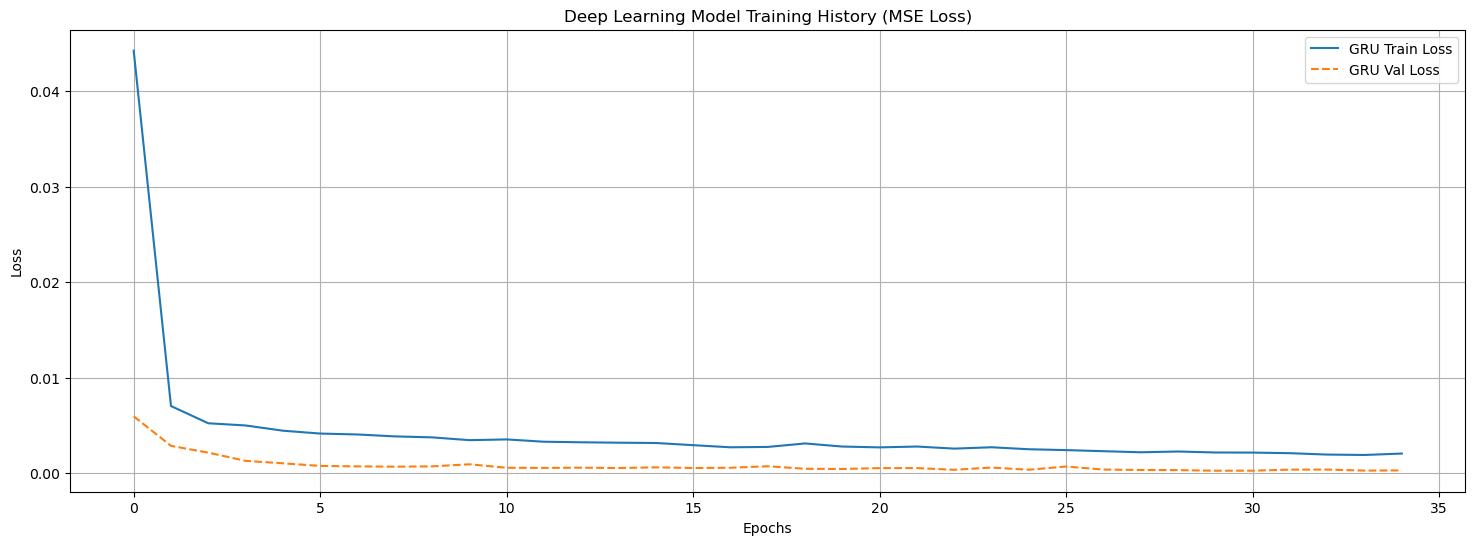

In [189]:
# Call the function
plot_history(
    histories=[history_gru],
    names=[ 'GRU']
)

In [190]:
rmse_gru, mae_gru, r2_gru = evaluate_model(gru_model, X_test, y_test)
# Print results
print(f"GRU Model Performance:")
print(f"RMSE: {rmse_gru:.4f}")
print(f"MAE: {mae_gru:.4f}")
print(f"R²: {r2_gru:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
GRU Model Performance:
RMSE: 0.0166
MAE: 0.0133
R²: 0.9956


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


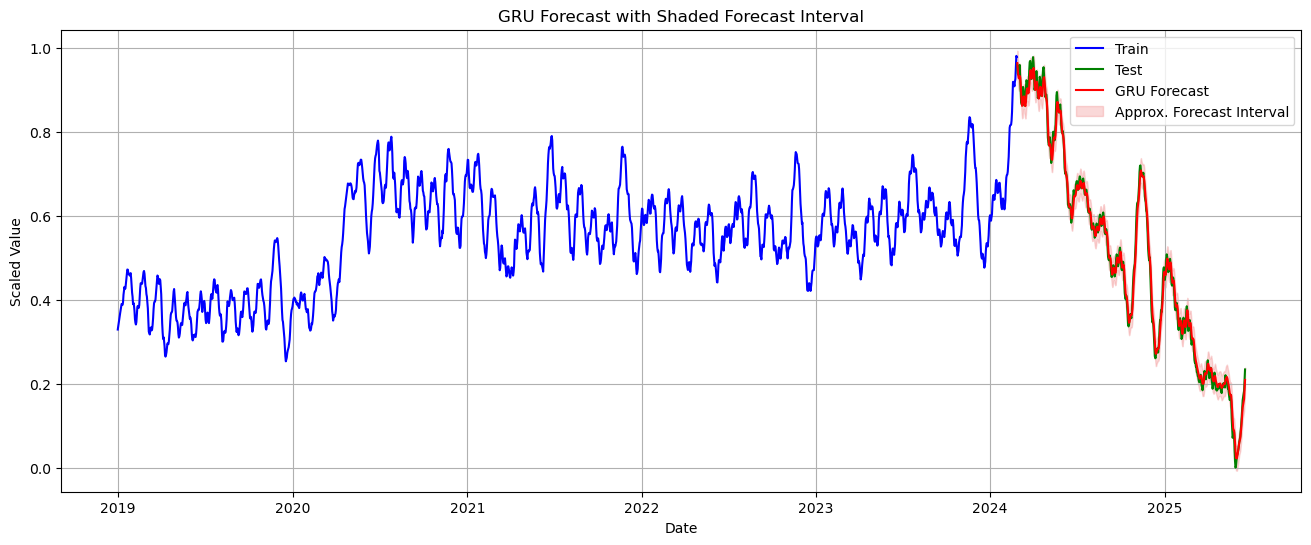

In [191]:
# Predict on test set
y_pred_gru = gru_model.predict(X_test).flatten()

# Compute residuals on train for approximate uncertainty
residuals = y_train -gru_model.predict(X_train).flatten()
rolling_std = np.std(residuals)

# Upper and lower bounds
upper_bound = y_pred_gru + 2*rolling_std
lower_bound = y_pred_gru - 2*rolling_std

# Plot
plt.figure(figsize=(16,6))
plt.plot(df_feat.index[:len(y_train)], y_train, label='Train', color='blue')
plt.plot(df_feat.index[len(y_train):len(y_train)+len(y_test)], y_test, label='Test', color='green')
plt.plot(df_feat.index[len(y_train):len(y_train)+len(y_test)], y_pred_gru, label='GRU Forecast', color='red')
plt.fill_between(
    df_feat.index[len(y_train):len(y_train)+len(y_test)],
    lower_bound,
    upper_bound,
    color='lightcoral',
    alpha=0.3,
    label='Approx. Forecast Interval'
)
plt.title("GRU Forecast with Shaded Forecast Interval")
plt.xlabel("Date")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)
plt.show()


In [192]:
# Get top 5 predictions and actuals from the test set
top5_actual = y_test[:5]
top5_pred   = y_pred_gru[:5]

# Inverse transform (assuming you used a scaler like StandardScaler or MinMaxScaler)
top5_actual_orig = scaler_y.inverse_transform(top5_actual.reshape(-1,1)).flatten()
top5_pred_orig   = scaler_y.inverse_transform(top5_pred.reshape(-1,1)).flatten()

# Print nicely
print("Top 5 Actual vs Predicted Transaction volume (GRU)")
print("------------------------------------------------------")
for i in range(5):
    print(f"Actual   : {top5_actual_orig[i]:.2f} | Predicted : {top5_pred_orig[i]:.2f}")

Top 5 Actual vs Predicted Transaction volume (GRU)
------------------------------------------------------
Actual   : 28.59 | Predicted : 28.65
Actual   : 28.22 | Predicted : 28.39
Actual   : 28.18 | Predicted : 28.16
Actual   : 28.18 | Predicted : 28.04
Actual   : 28.33 | Predicted : 28.02


# Bi-GRU

In [193]:
def build_bigru(input_shape):
    model = Sequential()
    model.add(Bidirectional(GRU(64, activation="tanh", return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(32)))
    model.add(Dense(1))
    model.compile(optimizer="adam",  loss='mse', metrics=['mae'])
    return model


bigru_model = build_bigru(input_shape)
history_bigru = bigru_model.fit(X_train, y_train, validation_data=(X_test, y_test),
                                epochs=Epochs, 
                                batch_size=Batch_size, 
                                callbacks=[early_stop],
                                verbose=1)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0330 - mae: 0.1443 - val_loss: 0.0024 - val_mae: 0.0401
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - mae: 0.0422 - val_loss: 0.0019 - val_mae: 0.0358
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0022 - mae: 0.0371 - val_loss: 0.0013 - val_mae: 0.0288
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mae: 0.0358 - val_loss: 0.0011 - val_mae: 0.0276
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mae: 0.0336 - val_loss: 9.1629e-04 - val_mae: 0.0244
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mae: 0.0312 - val_loss: 8.1324e-04 - val_mae: 0.0230
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - mae: 0.0292 - val_loss: 6.7230e-04 - val_mae: 0.0201
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - mae: 0.0289 - val_loss: 6.8903e-04 - val_mae: 0.0213
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - 

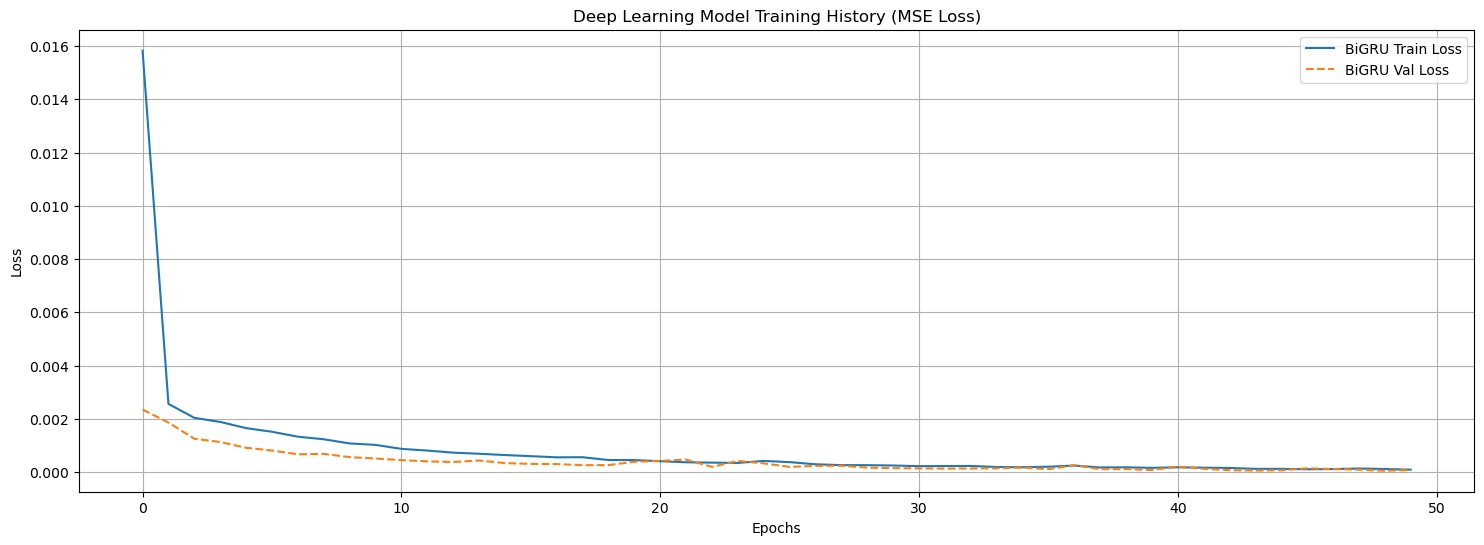

In [194]:
# Call the function
plot_history( [history_bigru], ['BiGRU'])

In [195]:
rmse_bigru, mae_bigru, r2_bigru = evaluate_model(bigru_model, X_test, y_test)
print(f"BiGRU -> RMSE: {rmse_bigru:.4f}, MAE: {mae_bigru:.4f}, R2: {r2_bigru:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
BiGRU -> RMSE: 0.0075, MAE: 0.0058, R2: 0.9991


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


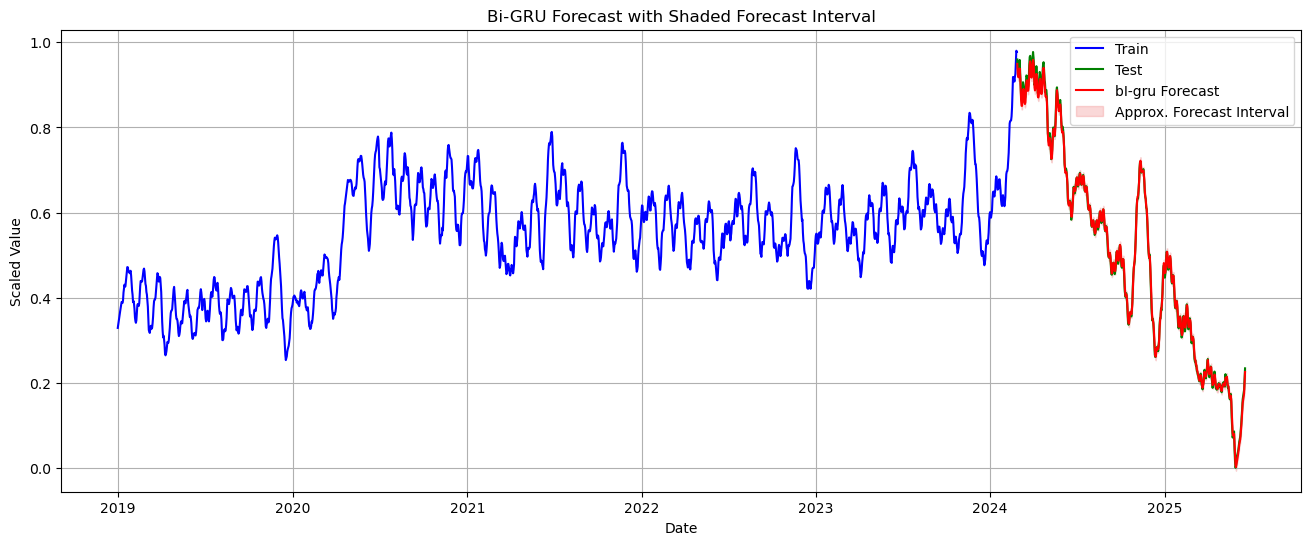

In [196]:
# Predict on test set
y_pred_bigru = bigru_model.predict(X_test).flatten()

# Compute residuals on train for approximate uncertainty
residuals = y_train - bigru_model.predict(X_train).flatten()
rolling_std = np.std(residuals)

# Upper and lower bounds
upper_bound = y_pred_bigru + 2*rolling_std
lower_bound = y_pred_bigru - 2*rolling_std

# Plot
plt.figure(figsize=(16,6))
plt.plot(df_feat.index[:len(y_train)], y_train, label='Train', color='blue')
plt.plot(df_feat.index[len(y_train):len(y_train)+len(y_test)], y_test, label='Test', color='green')
plt.plot(df_feat.index[len(y_train):len(y_train)+len(y_test)], y_pred_bigru, label='bI-gru Forecast', color='red')
plt.fill_between(
    df_feat.index[len(y_train):len(y_train)+len(y_test)],
    lower_bound,
    upper_bound,
    color='lightcoral',
    alpha=0.3,
    label='Approx. Forecast Interval'
)
plt.title("Bi-GRU Forecast with Shaded Forecast Interval")
plt.xlabel("Date")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)
plt.show()


In [197]:
# 5 predictions and actuals 
top5_actual = y_test[:5]
top5_pred   = y_pred_bigru[:5]
# Inverse transform
top5_actual = scaler_y.inverse_transform(top5_actual.reshape(-1,1)).flatten()
top5_pred   = scaler_y.inverse_transform(top5_pred.reshape(-1,1)).flatten()

# Print them nicely
print("Top 5 Actual vs Predicted Volume (Bi-GRU)")
print("------------------------------------------")
for i in range(5):
    print(f"Actual   : {top5_actual[i]:.4f} | Predicted : {top5_pred[i]:.4f}")

Top 5 Actual vs Predicted Volume (Bi-GRU)
------------------------------------------
Actual   : 28.5915 | Predicted : 28.4139
Actual   : 28.2241 | Predicted : 28.0227
Actual   : 28.1800 | Predicted : 27.8885
Actual   : 28.1806 | Predicted : 27.8787
Actual   : 28.3344 | Predicted : 28.0050


# RESULTS

In [198]:
# Predictions
y_pred_lstm = lstm_model.predict(X_test).flatten()
y_pred_gru = gru_model.predict(X_test).flatten()
y_pred_bigru = bigru_model.predict(X_test).flatten()

# Approximate forecast intervals using train residuals
rolling_std_lstm = np.std(y_train - lstm_model.predict(X_train).flatten())
rolling_std_gru = np.std(y_train - gru_model.predict(X_train).flatten())
rolling_std_bigru = np.std(y_train - bigru_model.predict(X_train).flatten())

upper_lstm = y_pred_lstm + 2*rolling_std_lstm
lower_lstm = y_pred_lstm - 2*rolling_std_lstm

upper_gru = y_pred_gru + 2*rolling_std_gru
lower_gru = y_pred_gru - 2*rolling_std_gru

upper_bigru = y_pred_bigru + 2*rolling_std_bigru
lower_bigru = y_pred_bigru - 2*rolling_std_bigru

# Time index
train_idx = df_feat.index[:len(y_train)]
test_idx = df_feat.index[len(y_train):len(y_train)+len(y_test)]

# Create figure
fig = go.Figure()

# Train
fig.add_trace(go.Scatter(x=train_idx, y=y_train, mode='lines', name='Train', line=dict(color='blue')))

# Test
fig.add_trace(go.Scatter(x=test_idx, y=y_test, mode='lines', name='Test', line=dict(color='green')))

# LSTM Forecast + interval
fig.add_trace(go.Scatter(x=test_idx, y=y_pred_lstm, mode='lines', name='LSTM Forecast', line=dict(color='red')))
fig.add_trace(go.Scatter(
    x=np.concatenate([test_idx, test_idx[::-1]]),
    y=np.concatenate([upper_lstm, lower_lstm[::-1]]),
    fill='toself', fillcolor='rgba(255,0,0,0.2)', line=dict(color='rgba(255,0,0,0)'),
    hoverinfo="skip", showlegend=True, name='LSTM Interval'
))

# GRU Forecast + interval
fig.add_trace(go.Scatter(x=test_idx, y=y_pred_gru, mode='lines', name='GRU Forecast', line=dict(color='orange')))
fig.add_trace(go.Scatter(
    x=np.concatenate([test_idx, test_idx[::-1]]),
    y=np.concatenate([upper_gru, lower_gru[::-1]]),
    fill='toself', fillcolor='rgba(255,165,0,0.2)', line=dict(color='rgba(255,165,0,0)'),
    hoverinfo="skip", showlegend=True, name='GRU Interval'
))

# BiGRU Forecast + interval
fig.add_trace(go.Scatter(x=test_idx, y=y_pred_bigru, mode='lines', name='BiGRU Forecast', line=dict(color='purple')))
fig.add_trace(go.Scatter(
    x=np.concatenate([test_idx, test_idx[::-1]]),
    y=np.concatenate([upper_bigru, lower_bigru[::-1]]),
    fill='toself', fillcolor='rgba(128,0,128,0.2)', line=dict(color='rgba(128,0,128,0)'),
    hoverinfo="skip", showlegend=True, name='BiGRU Interval'
))

# Layout
fig.update_layout(
    title='Deep Learning Forecasts with Shaded Intervals',
    xaxis_title='Date',
    yaxis_title='Scaled Value',
    template='plotly_white',
    legend=dict(x=0.01, y=0.99)
)

fig.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [199]:
metrics_df = pd.DataFrame({
    'Model': ['ARIMAX', 'LSTM', 'GRU', 'BiGRU'],
    'RMSE': [rmse, rmse_lstm, rmse_gru, rmse_bigru],
    'MAE': [mae, mae_lstm, mae_gru, mae_bigru],
    'R²': [r2, r2_lstm, r2_gru, r2_bigru]
})

print(metrics_df)


    Model      RMSE       MAE        R²
0  ARIMAX  0.047435  0.040654  0.965122
1    LSTM  0.027719  0.022483  0.987750
2     GRU  0.016575  0.013250  0.995620
3   BiGRU  0.007471  0.005849  0.999110


In [200]:
# Top 5 actuals and predictions for each model
top5_actual = y_test[:5]
top5_pred_gru    = y_pred_gru[:5]
top5_pred_lstm   = y_pred_lstm[:5]
top5_pred_bigru  = y_pred_bigru[:5]

# Use scaler_y for inverse-transforming all values
top5_actual_orig    = scaler_y.inverse_transform(top5_actual.reshape(-1,1)).flatten()
top5_pred_gru_orig  = scaler_y.inverse_transform(top5_pred_gru.reshape(-1,1)).flatten()
top5_pred_lstm_orig = scaler_y.inverse_transform(top5_pred_lstm.reshape(-1,1)).flatten()
top5_pred_bigru_orig= scaler_y.inverse_transform(top5_pred_bigru.reshape(-1,1)).flatten()

# Create combined DataFrame
df_compare_all = pd.DataFrame({
    'Actual': top5_actual_orig,
    'GRU_Predicted': top5_pred_gru_orig,
    'LSTM_Predicted': top5_pred_lstm_orig,
    'BiGRU_Predicted': top5_pred_bigru_orig,
})

print("Top 5 Actual vs Predicted")
print(df_compare_all)

Top 5 Actual vs Predicted
      Actual  GRU_Predicted  LSTM_Predicted  BiGRU_Predicted
0  28.591481      28.647320       28.991463        28.413927
1  28.224145      28.389624       28.953688        28.022684
2  28.180045      28.163891       28.738590        27.888466
3  28.180558      28.035686       28.484030        27.878687
4  28.334407      28.024532       28.261396        28.005001
